# Use spectra of CTIO Data in January 2017 to do atmospheric studies
==================================================================================================

- author : Sylvie Dagoret-Campagne
- date   : January 16th 2017
- update : February 15th 2017


This notebook is supposed to perform an atmospheric properties measurement on spectra




In [198]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [199]:
print theNotebook

AnaAerCalibDataSim_Spectrum_HD60753


In [200]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os
import pandas as pd

In [201]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [202]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

In [203]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.0.0


In [204]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [205]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [206]:
from IPython.display import Image, display

In [207]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [208]:
from scipy.interpolate import interp1d

In [209]:
import datetime
from dateutil import parser  # very usefull time format smart parser

In [210]:
from matplotlib.dates import MonthLocator, WeekdayLocator,DateFormatter
from matplotlib.dates import MONDAY

In [211]:
mondays = WeekdayLocator(MONDAY)
months = MonthLocator(range(1, 13), bymonthday=1, interval=1)
monthsFmt = DateFormatter("%b '%y")

In [212]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [213]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

In [214]:
class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of 
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in 
        IPython Notebook. """
    
    def _repr_html_(self):
        html = ["<table>"]
        for row in self:
            html.append("<tr>")
            
            for col in row:
                html.append("<td>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)

In [215]:
def truncate(f, n):
    '''Truncates/pads a float f to n decimal places without rounding'''
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])

### Output directory for images generated in the notebook view (not true fits images)¶¶

In [216]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images

In [217]:
ensure_dir(dir_top_images) # create that directory

### Input fits file

In [218]:
inputdir="./spectrum_calibcompsimrealspec"
object_name='HD60753'

### Output Fits file

In [219]:
outputdir="./spectrum_anaaer"

In [220]:
ensure_dir(outputdir)

In [221]:
output_file='AnaAtmAerFromSpectra_'+object_name+'.csv'

## Location of calibrated spectra and Simulations
----------------------------------

In [222]:
input_filelist=os.listdir(inputdir) 

In [223]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [224]:
print input_filelist[0:5]

['compSimRealSpectra_HD60753_20170118_432.fits'
 'compSimRealSpectra_HD60753_20170118_433.fits'
 'compSimRealSpectra_HD60753_20170118_434.fits'
 'compSimRealSpectra_HD60753_20170118_435.fits'
 'compSimRealSpectra_HD60753_20170118_436.fits']


In [225]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list

In [226]:
#%%cython

import numpy as np
import re

def MakeFileList(inputdir,input_filelist):
    """
    MakeFileList : Make The List of files to open
    =============
    """
    
#    import numpy as np
#    import re
    indexes_files= [] # global list
    filelist_fitsimages= []  # global list
    
    for file in input_filelist: # loop on directories, one per image       
            filename=inputdir+'/'+file     
            if re.search('.*fits$',filename):  #example of filename filter
                num_str=re.findall('^compSimRealSpectra_HD60753_20170118_([0-9]+).fits',file)[0]
                index=int(num_str)
                filelist_fitsimages.append(filename)
                indexes_files.append(index)   
                
                
    return indexes_files, filelist_fitsimages

In [227]:
indexes_files, filelist_fitsimages=MakeFileList(inputdir,input_filelist)   # filter to select fits file only

In [228]:
# transform into numpy arrays
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [229]:
print indexes_files

[432 433 434 435 436 437 438 439 440 441]


In [230]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [231]:
sorted_numbers=indexes_files[sorted_indexes]

In [232]:
print sorted_indexes

[0 1 2 3 4 5 6 7 8 9]


In [233]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

In [234]:
sorted_files[0:5]

array([ './spectrum_calibcompsimrealspec/compSimRealSpectra_HD60753_20170118_432.fits',
       './spectrum_calibcompsimrealspec/compSimRealSpectra_HD60753_20170118_433.fits',
       './spectrum_calibcompsimrealspec/compSimRealSpectra_HD60753_20170118_434.fits',
       './spectrum_calibcompsimrealspec/compSimRealSpectra_HD60753_20170118_435.fits',
       './spectrum_calibcompsimrealspec/compSimRealSpectra_HD60753_20170118_436.fits'], 
      dtype='|S76')

## Build full filename
----------------------------

In [235]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(inputdir,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [236]:
#sorted_filenames=np.array(sorted_filenames)
sorted_filenames=np.copy(sorted_files)

In [237]:
print sorted_filenames.shape

(10,)


## Acces to spectrum data
----------------------------------

In [238]:
all_dates = []
all_airmass = []
all_spectra = []
all_titles = []
all_header = []
all_img = []

In [239]:
%%cython

import numpy as np
from astropy.io import fits

def BuildCalibSpec(sorted_filenames,sorted_numbers,object_name):
    """
    BuildRawSpec
    ===============
    """

    all_dates = []
    all_airmass = []
    all_leftspectra_data = []
    all_rightspectra_data = []
    all_leftspectra_sim = []
    all_rightspectra_sim = []
    all_leftspectra_wl = []
    all_rightspectra_wl = []
    all_titles = []
    all_header = []
    all_expo = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        
        #hdu_list.info()
        
        header=hdu_list[0].header
        #print header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        expo = header['EXPTIME']
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        
        # now reads the spectra
        
        table_data=hdu_list[1].data
        
        #cols = hdu_list[1].columns
        #cols.info()
        #print hdu_list[1].columns
        #cols.names
  
        #col1=fits.Column(name='CalibLeftSpecWL',format='E',array=theleftwl_cut[idx[0]])
        #col2=fits.Column(name='CalibLeftSpecData',format='E',array=theleftspectrum_cut[idx[0]])
        #col3=fits.Column(name='CalibLeftSpecSim',format='E',array=theleftsimspec_cut[idx[0]])
        #col4=fits.Column(name='CalibRightSpecWL',format='E',array=therightwl_cut[idx[0]])
        #col5=fits.Column(name='CalibRightSpecData',format='E',array=therightspectrum_cut[idx[0]])
        #col6=fits.Column(name='CalibRightSpecSim',format='E',array=therightsimspec_cut[idx[0]])
    
    
        left_spectrum_wl=table_data.field('CalibLeftSpecWL')
        left_spectrum_data=table_data.field('CalibLeftSpecData')
        left_spectrum_sim=table_data.field('CalibLeftSpecSim')
        
        right_spectrum_wl=table_data.field('CalibRightSpecWL')
        right_spectrum_data=table_data.field('CalibRightSpecData')
        right_spectrum_sim=table_data.field('CalibRightSpecSim')
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        
        all_leftspectra_data.append(left_spectrum_data)
        all_rightspectra_data.append(right_spectrum_data)
        
        all_leftspectra_wl.append(left_spectrum_wl)
        all_rightspectra_wl.append(right_spectrum_wl)
        
        all_leftspectra_sim.append(left_spectrum_sim)
        all_rightspectra_sim.append(right_spectrum_sim)
        
        all_titles.append(title)
        all_header.append(header)
        all_expo.append(expo)
        hdu_list.close()
        
    return all_dates,all_airmass,all_titles,all_header,all_expo,all_leftspectra_data,all_rightspectra_data,all_leftspectra_sim,all_rightspectra_sim,all_leftspectra_wl, \
        all_rightspectra_wl

In [240]:
all_dates,all_airmass,all_titles,all_header,all_expo,all_leftspectra_data,all_rightspectra_data,all_leftspectra_sim,all_rightspectra_sim,all_leftspectra_wl,all_rightspectra_wl=BuildCalibSpec(sorted_files,sorted_numbers,object_name)

In [241]:
print len(all_dates)

10


## 1.) Show Spectra
==========================

In [242]:
NDATA=len(all_rightspectra_data)

In [243]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
    
def ShowSpectra(all_spectra,all_ssim,all_wl,all_titles,object_name):
    """
    ShowSpectra: Show the raw images without background subtraction
    ==============
    """
    NBIMAGES=len(all_spectra)
    MAXIMGROW=int(NBIMAGES/5)+1
    thex0 = []
    f, axarr = plt.subplots(MAXIMGROW,5,figsize=(25,60))
    f.tight_layout()
    #plt.subplot_tool() 
    for index in np.arange(0,NBIMAGES):
        ix=index%5
        iy=index/5
        spectrum=all_spectra[index]
        spectrumsim=all_ssim[index]
        wl=all_wl[index]
        axarr[iy,ix].plot(wl,spectrum,'r-',lw=2,label='data')
        axarr[iy,ix].plot(wl,spectrumsim,'b-',lw=2,label='sim')
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].set_ylim(0.,3000.)
        axarr[iy,ix].set_xlim(100.,1100.)
        
        axarr[iy,ix].get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
        axarr[iy,ix].get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
        axarr[iy,ix].grid(b=True, which='major', color='k', linewidth=2.0)
        axarr[iy,ix].grid(b=True, which='minor', color='k', linewidth=0.5)
      
        
    
    #title='spectra'
    #plt.suptitle(title,size=16)
   

### Work only on right spectra

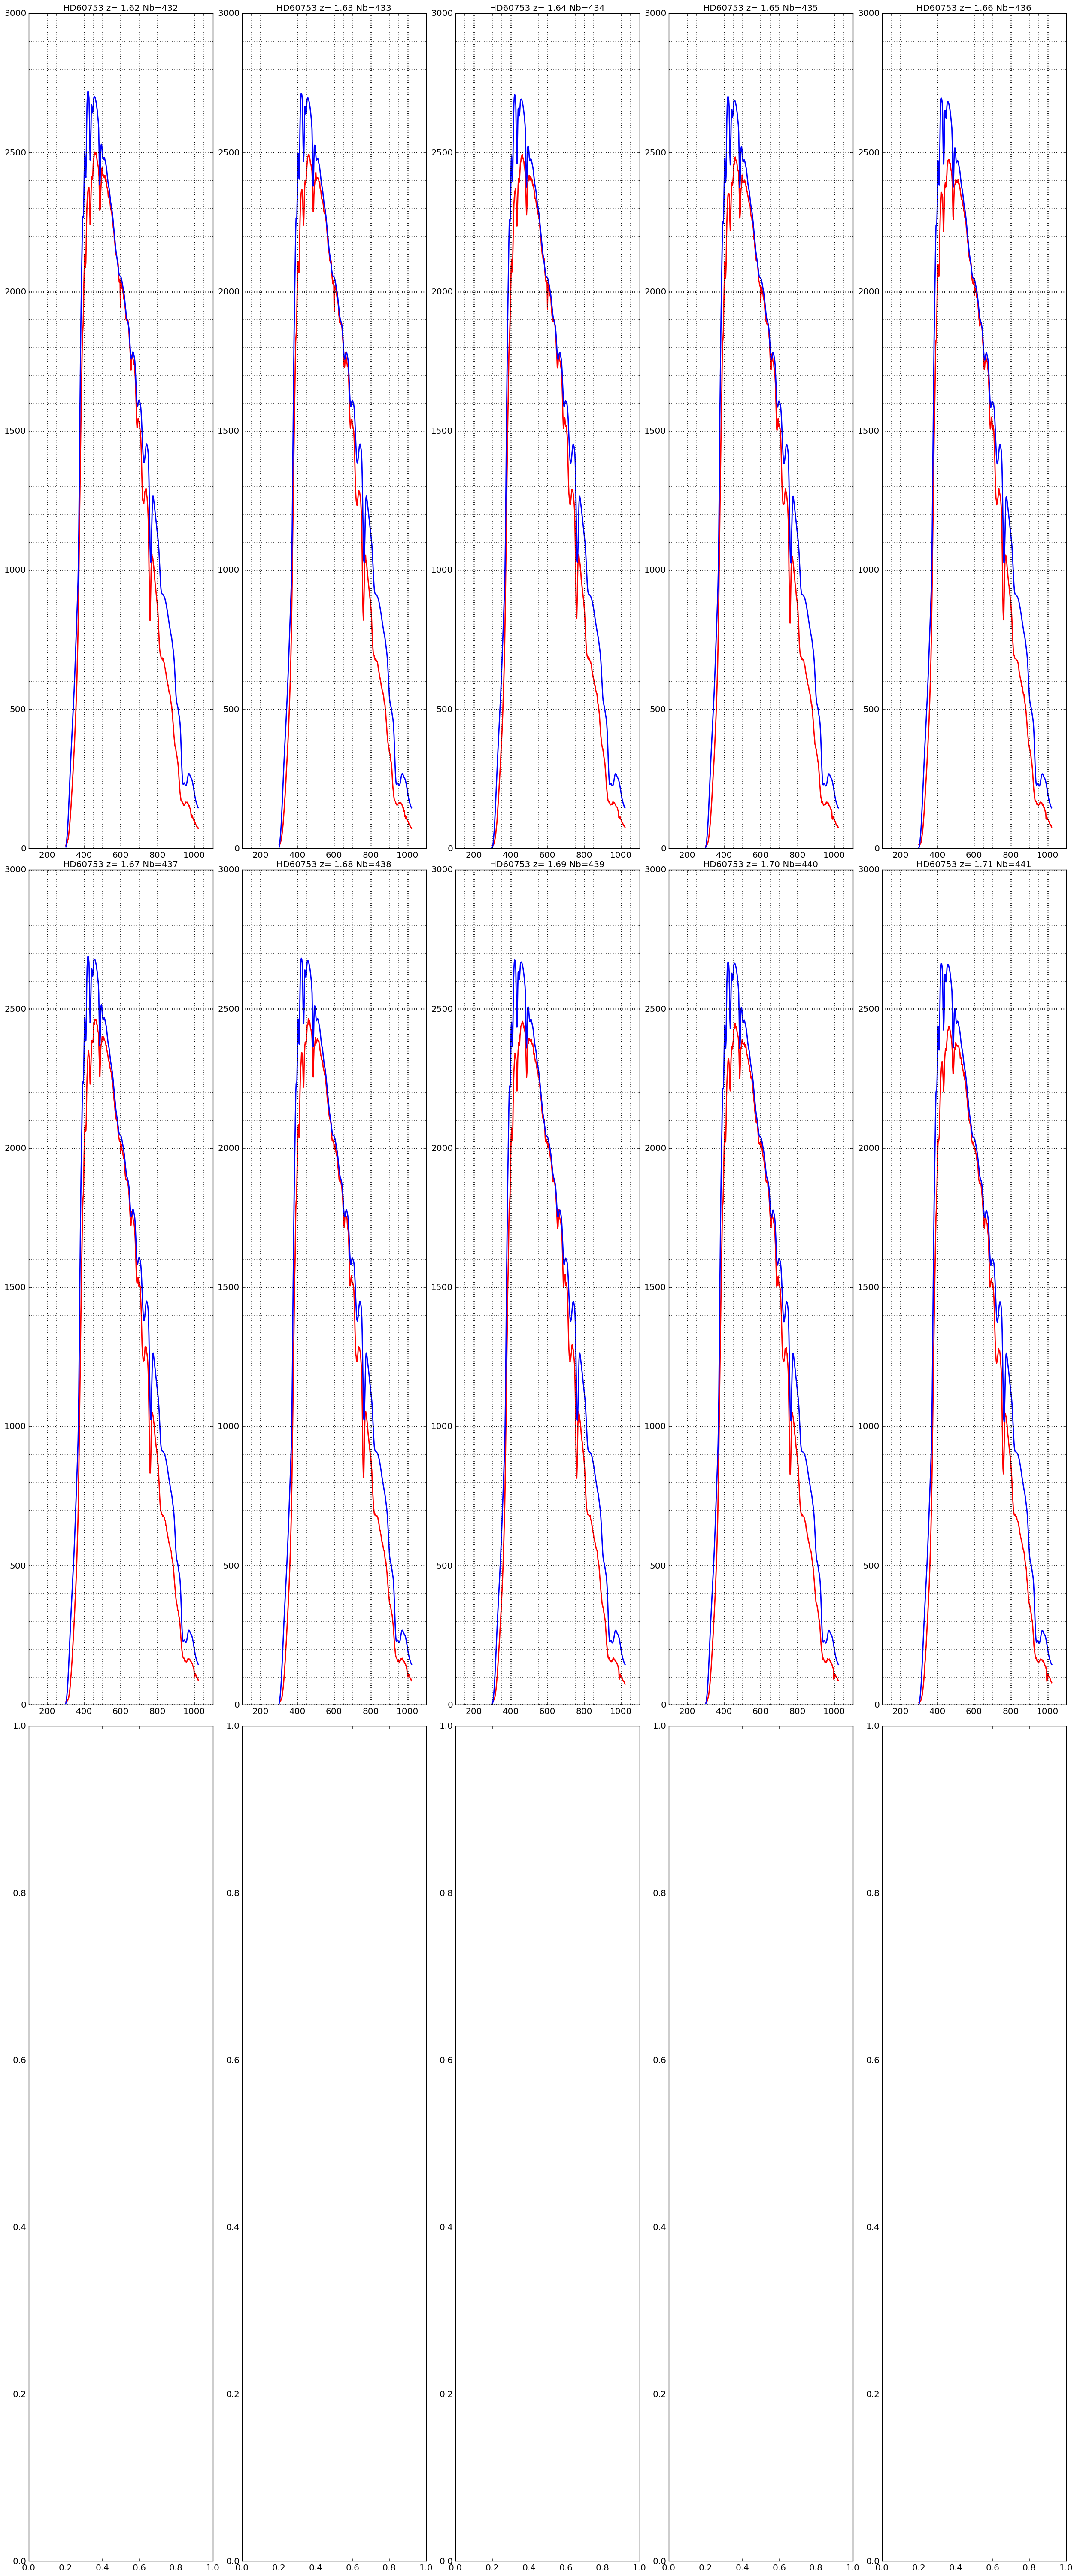

In [244]:
ShowSpectra(all_rightspectra_data,all_rightspectra_sim,all_rightspectra_wl,all_titles,object_name)

In [245]:
wl_O2Aline=759.37      # Balmer Lines
wl_O2Bline=686.719
wl_Haline=656.281 
wl_Hbline=486.134
wl_Hgline=434.047 
wl_Hdline=410.175
wl_Heline=397.0

In [246]:
sel=1
thespectrum=all_rightspectra_data[sel]

In [247]:
#thespectrum

In [248]:
#print all_rightspectra_data[sel]

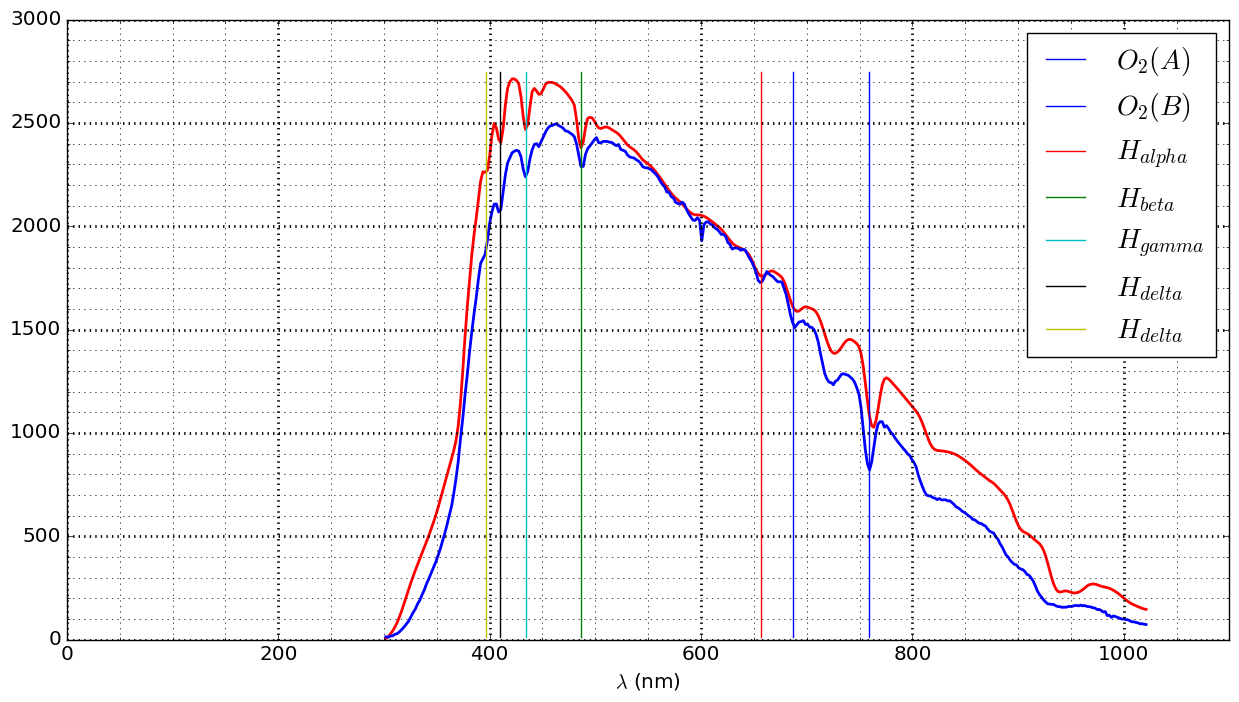

In [249]:
sel=1
thespectrum=all_rightspectra_data[sel]
thesimspectrum=all_rightspectra_sim[sel]

thewl=all_rightspectra_wl[sel]
ymin=thespectrum.min()
ymax=thespectrum.max()*1.1

fig, ax = plt.subplots(1, 1, figsize=(15,8))

ax.plot(thewl,thesimspectrum,'r-',lw=2)
ax.plot(thewl,thespectrum,'b-',lw=2)

ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='k', linewidth=2.0)
ax.grid(b=True, which='minor', color='k', linewidth=0.5)

ax.plot([wl_O2Aline,wl_O2Aline],[ymin,ymax],'b-',label='$O_2(A)$',lw=1)
ax.plot([wl_O2Bline,wl_O2Bline],[ymin,ymax],'b-',label='$O_2(B)$',lw=1)
ax.plot([wl_Haline,wl_Haline],[ymin,ymax],'r-',label='$H_{alpha}$',lw=1)
ax.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'g-',label='$H_{beta}$',lw=1)
ax.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=1)
ax.plot([wl_Hdline,wl_Hdline],[ymin,ymax],'k-',label='$H_{delta}$',lw=1)
ax.plot([wl_Heline,wl_Heline],[ymin,ymax],'y-',label='$H_{delta}$',lw=1)

ax.legend(loc='best',fontsize=20)
ax.set_xlim(0,1100)
ax.set_xlabel("$\lambda$ (nm)")

## 2.) Study ratio Data/Sim spectra
============================================

In [250]:
def ShowRatioSpectra(thewl,thespectrum,thesimspec,all_titles,object_name):
    """
    ShowRatioSpectra: Show the camibration curve
    ==============
    """

    NBSPECTRA=len(thespectrum)
    
    fig, ax = plt.subplots(1, 1, figsize=(15,8))

    all_ymin= []
    all_ymax=[]
    
    for index in np.arange(0,NBSPECTRA):
        ix=index%5
        iy=index/5
                  
        ratio=thespectrum[index]/thesimspec[index]
        all_ymin.append(ratio.min())
        all_ymax.append(ratio.max())
        
        if(all_expo[index] >0 ):
            ax.plot(thewl[index],ratio,'-',lw=2)
       
    ymin=np.array(all_ymin).min() 
    ymax=np.array(all_ymax).max()*1.1   
        
    #ax.set_xlim(0.,1000.)
    ax.set_ylim(0,1.5)
    
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)
    
    ax.plot([wl_O2Aline,wl_O2Aline],[ymin,ymax],'b-',label='$O_2(A)$',lw=1)
    ax.plot([wl_O2Bline,wl_O2Bline],[ymin,ymax],'b-',label='$O_2(B)$',lw=1)
    ax.plot([wl_Haline,wl_Haline],[ymin,ymax],'r-',label='$H_{alpha}$',lw=1)
    ax.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'g-',label='$H_{beta}$',lw=1)
    ax.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=1)
    ax.plot([wl_Hdline,wl_Hdline],[ymin,ymax],'k-',label='$H_{delta}$',lw=1)
    ax.legend(loc='best',fontsize=20)
    title='Ratio of Data/Sim spectra for object {}'.format(object_name)
    
    ax.set_title(title)
    ax.set_ylabel("ratio")
    ax.set_xlabel("$\lambda$ (nm)")

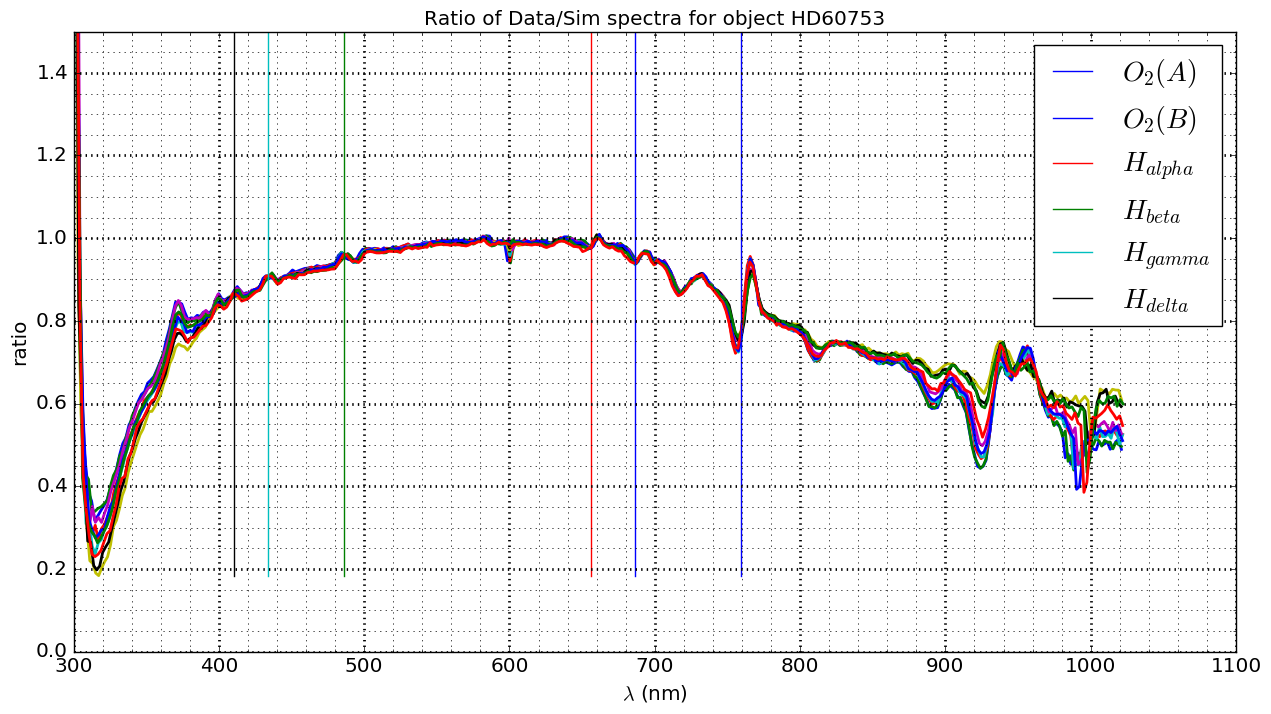

In [251]:
#all_rightspectra_data,all_rightspectra_sim,all_rightspectra_wl,all_titles,object_name
ShowRatioSpectra(all_rightspectra_wl,all_rightspectra_data,all_rightspectra_sim,all_titles,object_name)




## Average of Ratio Data/Sim

In [252]:
#np.where(all_rightspectra_wl[1]>wlcut)

In [253]:
wlcut=400

In [254]:
def ShowRatioSpectraSum(thewl,thespectrum,thesimspec,wlcut,all_titles,object_name):
    """
    ShowRatioSpectra: Show the camibration curve
    ==============
    """

    NBSPECTRA=len(thespectrum)

    # Plot 1) show the ratio data/Sim
    
    fig, ax = plt.subplots(1, 1, figsize=(15,6))

    all_ymin= []
    all_ymax=[]
    all_sum=[]
    
    for index in np.arange(0,NBSPECTRA):
        ix=index%5
        iy=index/5
         
        selectedindexes=np.where(all_rightspectra_wl[index]>wlcut)    
        sel_data=thespectrum[index][selectedindexes]
        sel_sim=thesimspec[index][selectedindexes]
        sel_wl=all_rightspectra_wl[index][selectedindexes]
        
        ratio=sel_data/sel_sim ## Compute here the ratio data/sim
        
        if(all_expo[index]>0):
            all_ymin.append(ratio.min())
            all_ymax.append(ratio.max())
            all_sum.append(ratio.mean())
                       
            ax.plot(sel_wl,ratio,'-',lw=2)
       
    ymin=np.array(all_ymin).min() 
    ymax=np.array(all_ymax).max()*1.1   
        
    #ax.set_xlim(0.,1000.)
    ax.set_ylim(0,1.5)
    
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)
    
    ax.plot([wl_O2Aline,wl_O2Aline],[ymin,ymax],'b-',label='$O_2(A)$',lw=1)
    ax.plot([wl_O2Bline,wl_O2Bline],[ymin,ymax],'b-',label='$O_2(B)$',lw=1)
    ax.plot([wl_Haline,wl_Haline],[ymin,ymax],'r-',label='$H_{alpha}$',lw=1)
    ax.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'g-',label='$H_{beta}$',lw=1)
    ax.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=1)
    ax.plot([wl_Hdline,wl_Hdline],[ymin,ymax],'k-',label='$H_{delta}$',lw=1)
    ax.legend(loc='best',fontsize=20)
    title='Ratio of Data/Sim spectra for object {}'.format(object_name)
    
    ax.set_title(title)
    ax.set_ylabel("ratio")
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_xlim(300.,1000.)
    
    ## plot 2 
    
    fig, ax = plt.subplots(1, 1, figsize=(15,6))
    plt.plot(all_sum,'ro')
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)
    title='Average of Ratio of Data/Sim spectra over wavelegth for object {}'.format(object_name)
    
    ax.set_title(title)
    ax.set_ylabel("ratio average ")
    ax.set_xlabel(" image number")
    return np.array(all_sum)

### Ratio versus image number

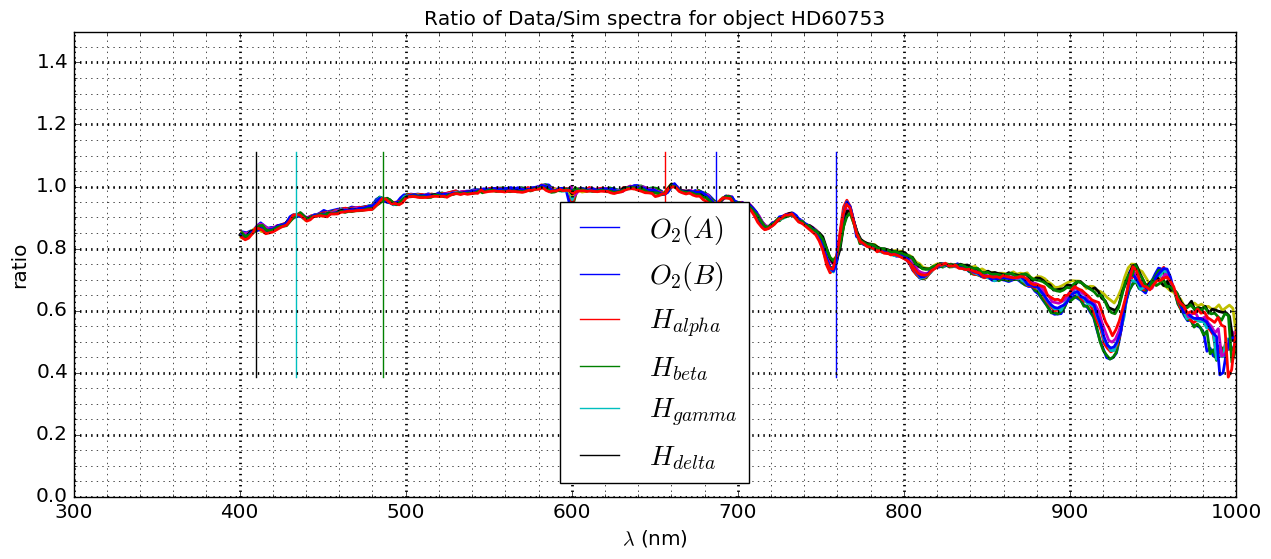

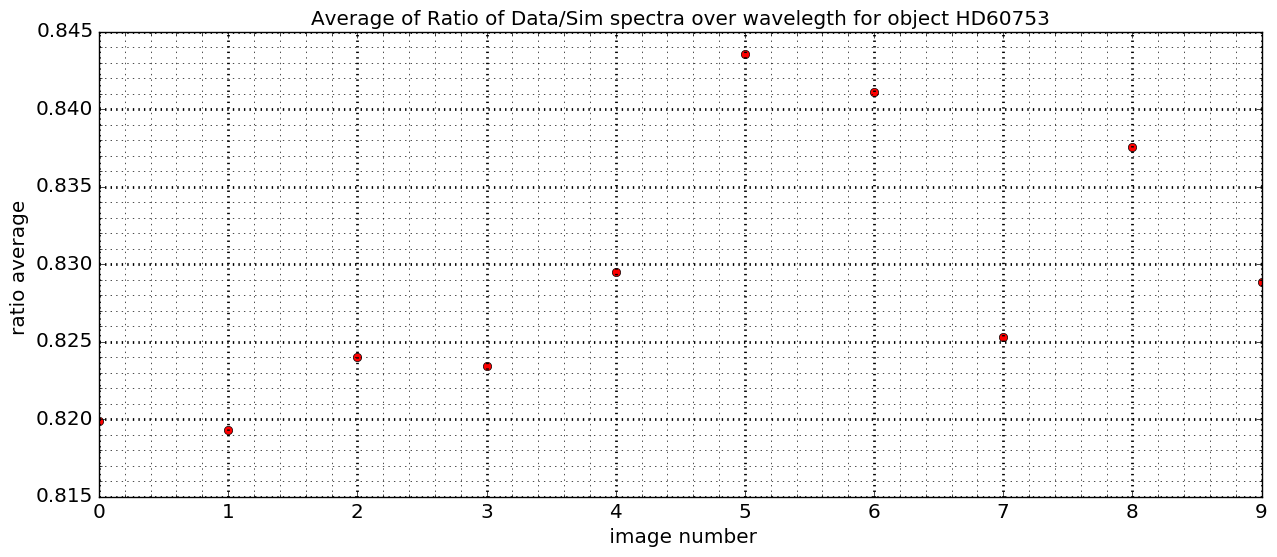

In [255]:
all_ratioaver=ShowRatioSpectraSum(all_rightspectra_wl,all_rightspectra_data,all_rightspectra_sim,wlcut,all_titles,object_name)

In [256]:
np.where(all_expo==0.)

(array([], dtype=int64),)

In [257]:
print all_expo

[60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0]


In [258]:
all_dt= [ parser.parse(all_dates[i]) for i in range(NDATA)]

In [259]:
all_airmass

[1.619, 1.629, 1.639, 1.649, 1.66, 1.67, 1.681, 1.692, 1.703, 1.714]

In [260]:
#all_dt

In [261]:
import matplotlib.dates as mdates

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
mins=mdates.MinuteLocator()
days=mdates.DayLocator()  # every day
hour=mdates.HourLocator()  # every day
yearsFmt = mdates.DateFormatter('%Y')


In [262]:
am=np.array(all_airmass)

In [263]:
print am

[ 1.619  1.629  1.639  1.649  1.66   1.67   1.681  1.692  1.703  1.714]


### Ratio versus image date

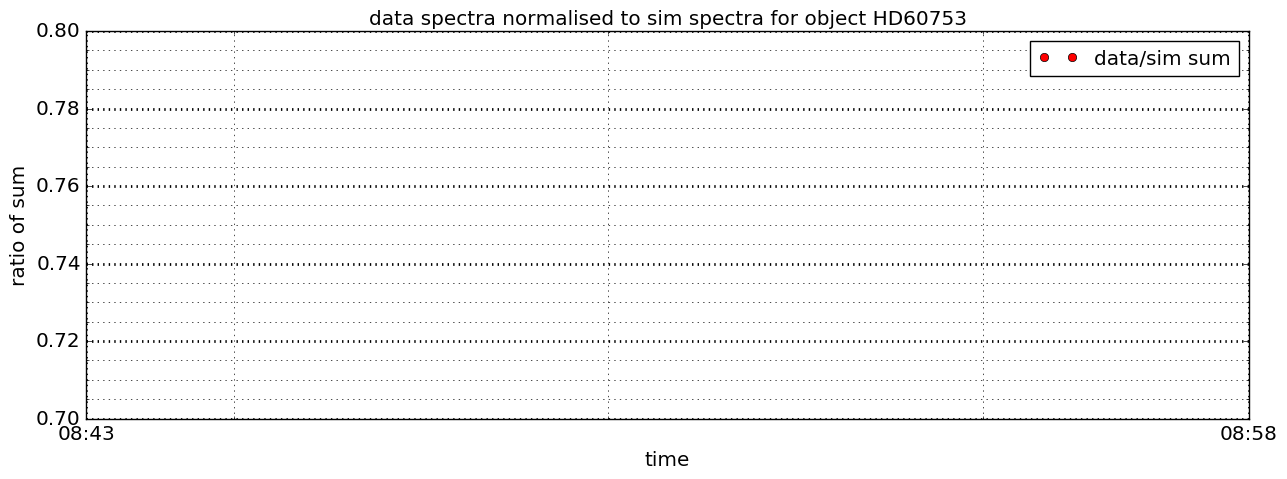

In [264]:
fig=plt.figure(figsize=(15,5))

ax=fig.add_subplot(1,1,1)
ax.plot_date(all_dt, all_ratioaver,marker='o',color='red',lw=0,label='data/sim sum',linewidth=3)
#ax.plot_date(all_dt, am,marker='.',color='blue',lw=0,label='relative airmass',linewidth=3)

ax.set_ylim(0.7,0.8)

date_range = all_dt[NDATA-1] - all_dt[0]

if date_range > datetime.timedelta(days = 1):
    ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=range(1,32), interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.get_xaxis().set_minor_locator(mdates.HourLocator(byhour=range(0,24,2)))
    #ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
else:
    ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0,24,2)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    #ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_xaxis().set_minor_locator(mdates.MinuteLocator(byminute=range(0,60,5)))
    
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())

ax.grid(b=True, which='major', color='k', linewidth=2.0)
ax.grid(b=True, which='minor', color='k', linewidth=0.5)
ax.set_ylabel('ratio of sum')
ax.set_xlabel('time')


title='data spectra normalised to sim spectra for object {}'.format(object_name)

plt.title(title)
plt.legend(loc='best')

#plt.savefig(figfilename1, bbox_inches='tight')

## 3.) Aerosols : phase 1 : (Data/Sim)(at z) / (Data/Sim)(at zmin)

In [265]:
def RemoveAbsorptionLines(thewl,thespectrum,thesimspec):
   
    
    WLMINAbs=np.array([405.,430.,480.,590,700,740])
    WLMAXAbs=np.array([415.,440.,500.,610,730,780])
    NAbsLines=WLMINAbs.shape[0]
    
    NBSPECTRA=len(thespectrum)
    
    all_selected_wl= []
    all_selected_dataspectrum= []
    all_selected_simspectrum= []
    
    for index in np.arange(0,NBSPECTRA):
        wl=np.copy(thewl[index])
        data=np.copy(thespectrum[index])
        sim=np.copy(thesimspec[index])
        
        not_selected_indexes=np.empty((0))  ### Create an empty array
               
        for iline in range(NAbsLines):     
        
            selected_to_add=np.where(np.logical_and(wl>WLMINAbs[iline],wl<WLMAXAbs[iline]))
            not_selected_indexes=np.append(not_selected_indexes,selected_to_add)

        
        all_selected_wl.append(np.delete(wl,not_selected_indexes))
        all_selected_dataspectrum.append(np.delete(data,not_selected_indexes))
        all_selected_simspectrum.append(np.delete(sim,not_selected_indexes))
        
        
    return np.array(all_selected_wl),np.array(all_selected_dataspectrum),np.array(all_selected_simspectrum) 

In [266]:
all_selected_wl,all_selected_dataspectrum,all_selected_simspectrum=RemoveAbsorptionLines(all_rightspectra_wl,all_rightspectra_data,all_rightspectra_sim)

In [267]:
print all_selected_wl[1].shape[0]
print all_selected_dataspectrum[1].shape[0]
print all_selected_simspectrum[1].shape[0]

290
290
290


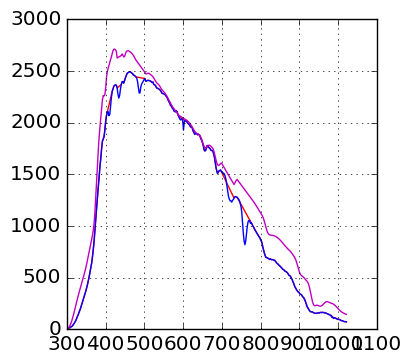

In [268]:
plt.plot(all_selected_wl[1],all_selected_dataspectrum[1],'r-')
plt.plot(all_rightspectra_wl[1],all_rightspectra_data[1],'b-')
plt.plot(all_selected_wl[1],all_selected_simspectrum[1],'m-')
plt.grid()

In [269]:
#all_airmass

## True Bouguer line on data spectrum

In [270]:
def bougline(x, a, b):
    return a*x + b

In [271]:
def ShowTrueBouguer(thewl,thespec,thezam):
    """
    ShowTrueBouguer:
    
    """
    
    fig, ax = plt.subplots(1, 1, figsize=(6,8))
    
    
    NBBands=6
    labels=["400-450nm", "450-500nm","500-550nm","550-600nm","600-650nm","650-700nm"]
    WLMINAbs=np.array([400.,450.,500.,550,600,650])
    WLMAXAbs=np.array([450.,500.,550.,600,650,700])
    
    NBSPEC=len(thespec)
    
    all_z = []
    all_log10S1vsZ = []
    all_log10S2vsZ = []
    all_log10S3vsZ = []
    all_log10S4vsZ = []
    all_log10S5vsZ = []
    all_log10S6vsZ = []
    all_log10S1vsZE = []
    all_log10S2vsZE = []
    all_log10S3vsZE = []
    all_log10S4vsZE = []
    all_log10S5vsZE = []
    all_log10S6vsZE = []
    
    fitparam = []
    all_yfit = []   
    xfit=np.linspace(1.,2.0,50)
    all_popt = []
    all_perr = []
    
    # loop on spectra
    for index in np.arange(NBSPEC):
        
        if all_expo[index]>0.: 
        
            thez=thezam[index]
              
            wl_current=thewl[index]
            wl_spec=thespec[index]
        
            nbwl=wl_current.shape[0]
        
            band1=np.where(np.logical_and(wl_current>= WLMINAbs[0],wl_current<WLMAXAbs[0]))
            band2=np.where(np.logical_and(wl_current>= WLMINAbs[1],wl_current<WLMAXAbs[1]))    
            band3=np.where(np.logical_and(wl_current>= WLMINAbs[2],wl_current<WLMAXAbs[2])) 
            band4=np.where(np.logical_and(wl_current>= WLMINAbs[3],wl_current<WLMAXAbs[3])) 
            band5=np.where(np.logical_and(wl_current>= WLMINAbs[4],wl_current<WLMAXAbs[4])) 
            band6=np.where(np.logical_and(wl_current>= WLMINAbs[5],wl_current<WLMAXAbs[5])) 
        
            all_S1=wl_spec[band1]
            all_S2=wl_spec[band2]
            all_S3=wl_spec[band3]
            all_S4=wl_spec[band4]
            all_S5=wl_spec[band5]
            all_S6=wl_spec[band6]
        
            all_log10S1 = 2.5*np.log10(all_S1)
            all_log10S2 = 2.5*np.log10(all_S2)
            all_log10S3 = 2.5*np.log10(all_S3)
            all_log10S4 = 2.5*np.log10(all_S4)
            all_log10S5 = 2.5*np.log10(all_S5)
            all_log10S6 = 2.5*np.log10(all_S6)
    
            all_z.append(thez)
            all_log10S1vsZ.append(np.average(all_log10S1))
            all_log10S2vsZ.append(np.average(all_log10S2))
            all_log10S3vsZ.append(np.average(all_log10S3))
            all_log10S4vsZ.append(np.average(all_log10S4))
            all_log10S5vsZ.append(np.average(all_log10S5))
            all_log10S6vsZ.append(np.average(all_log10S6))
            all_log10S1vsZE.append(np.std(all_log10S1)/np.sqrt(all_log10S1.shape[0]))
            all_log10S2vsZE.append(np.std(all_log10S2)/np.sqrt(all_log10S2.shape[0]))
            all_log10S3vsZE.append(np.std(all_log10S3)/np.sqrt(all_log10S3.shape[0]))
            all_log10S4vsZE.append(np.std(all_log10S4)/np.sqrt(all_log10S4.shape[0]))
            all_log10S5vsZE.append(np.std(all_log10S5)/np.sqrt(all_log10S5.shape[0]))
            all_log10S6vsZE.append(np.std(all_log10S6)/np.sqrt(all_log10S6.shape[0]))
    
    
    # band 1
    z = np.polyfit(all_z,all_log10S1vsZ, 1)
    fitparam.append(z)  
    print "--------------------------------------------------------------------------"
    print "z = ",z
    popt, pcov = curve_fit(bougline, all_z, all_log10S1vsZ,p0=z,sigma=all_log10S1vsZE)
    perr = np.sqrt(np.diag(pcov))
    
    print "popt = ",popt,' pcov',pcov,' perr',perr
    
    pol = np.poly1d(popt)
    yyyfit=pol(all_z)
    chi2sum=(yyyfit-np.array(all_log10S1vsZ))**2/np.array(all_log10S1vsZE)**2
    chi2=np.average(chi2sum)*chi2sum.shape[0]/(chi2sum.shape[0]-3)
    print 'chi2',chi2
    
    all_popt.append(popt)
    all_perr.append(perr)
    
    p = np.poly1d(z)
    yfit=p(xfit)
    y0fit=p(1.)
    all_yfit.append(yfit-y0fit)
    ax.plot(xfit,yfit-y0fit,'-',color='blue')        
    #ax.plot(all_z,all_log10S1vsZ-y0fit,'o-',color='blue',label=labels[0])
    ax.errorbar(all_z,all_log10S1vsZ-y0fit,yerr=all_log10S1vsZE,fmt='--o',color='blue',label=labels[0])
    
    
    # band 2
    z = np.polyfit(all_z,all_log10S2vsZ, 1)
    fitparam.append(z)    
    print "--------------------------------------------------------------------------"
    print "z = ",z
    popt, pcov = curve_fit(bougline, all_z, all_log10S2vsZ,p0=z,sigma=all_log10S2vsZE)
    perr = np.sqrt(np.diag(pcov))
    print "popt = ",popt,' pcov',pcov,' perr',perr
    pol = np.poly1d(popt)
    yyyfit=pol(all_z)
    chi2sum=(yyyfit-np.array(all_log10S2vsZ))**2/np.array(all_log10S2vsZE)**2
    chi2=np.average(chi2sum)*chi2sum.shape[0]/(chi2sum.shape[0]-3)
    print 'chi2',chi2
    
    all_popt.append(popt)
    all_perr.append(perr)
      
    p = np.poly1d(z)
    yfit=p(xfit)
    y0fit=p(1.)
    all_yfit.append(yfit-y0fit)
    ax.plot(xfit,yfit-y0fit,'-',color='green')  
    #ax.plot(all_z,all_log10S2vsZ-y0fit,'o-',color='green',label=labels[1])
    ax.errorbar(all_z,all_log10S2vsZ-y0fit,yerr=all_log10S2vsZE,fmt='--o',color='green',label=labels[1])
    
    # band 3
    z = np.polyfit(all_z,all_log10S3vsZ, 1)
    fitparam.append(z) 
    print "--------------------------------------------------------------------------"
    print "z = ",z
    popt, pcov = curve_fit(bougline, all_z, all_log10S3vsZ,p0=z,sigma=all_log10S3vsZE)
    perr = np.sqrt(np.diag(pcov))
    print "popt = ",popt,' pcov',pcov,' perr',perr
    pol = np.poly1d(popt)
    yyyfit=pol(all_z)
    chi2sum=(yyyfit-np.array(all_log10S3vsZ))**2/np.array(all_log10S3vsZE)**2
    chi2=np.average(chi2sum)*chi2sum.shape[0]/(chi2sum.shape[0]-3)
    print 'chi2',chi2
    all_popt.append(popt)
    all_perr.append(perr)
    
    p = np.poly1d(z)
    yfit=p(xfit)
    y0fit=p(1.)
    all_yfit.append(yfit-y0fit)
    ax.plot(xfit,yfit-y0fit,'-',color='red')  
    #ax.plot(all_z,all_log10S3vsZ-y0fit,'o-',color='red',label=labels[2])
    ax.errorbar(all_z,all_log10S3vsZ-y0fit,yerr=all_log10S3vsZE,fmt='--o',color='red',label=labels[2])
    #ax.plot(all_z,all_log10S4vsZ,'o-',color='magenta',label=labels[3])
    #ax.plot(all_z,all_log10S5vsZ,'o-',color='black',label=labels[4])
    #ax.plot(all_z,all_log10S6vsZ,'o-',color='grey',label=labels[5])
    
    # band 4
    z = np.polyfit(all_z,all_log10S4vsZ, 1)
    fitparam.append(z)  
    print "--------------------------------------------------------------------------"
    print "z = ",z
    popt, pcov = curve_fit(bougline, all_z, all_log10S4vsZ,p0=z,sigma=all_log10S4vsZE)
    perr = np.sqrt(np.diag(pcov))
    print "popt = ",popt,' pcov',pcov,' perr',perr
    pol = np.poly1d(popt)
    yyyfit=pol(all_z)
    chi2sum=(yyyfit-np.array(all_log10S4vsZ))**2/np.array(all_log10S4vsZE)**2
    chi2=np.average(chi2sum)*chi2sum.shape[0]/(chi2sum.shape[0]-3)
    print 'chi2',chi2
    all_popt.append(popt)
    all_perr.append(perr)
    p = np.poly1d(z)
    yfit=p(xfit)
    y0fit=p(1.)
    all_yfit.append(yfit-y0fit)
    ax.plot(xfit,yfit-y0fit,'-',color='magenta')  
    #ax.plot(all_z,all_log10S3vsZ-y0fit,'o-',color='red',label=labels[2])
    ax.errorbar(all_z,all_log10S4vsZ-y0fit,yerr=all_log10S4vsZE,fmt='--o',color='magenta',label=labels[3])
    
    # band 5
    z = np.polyfit(all_z,all_log10S5vsZ, 1)
    fitparam.append(z) 
    print "--------------------------------------------------------------------------"
    print "z = ",z
    popt, pcov = curve_fit(bougline, all_z, all_log10S5vsZ,p0=z,sigma=all_log10S5vsZE)
    perr = np.sqrt(np.diag(pcov))
    print "popt = ",popt,' pcov',pcov,' perr',perr
    pol = np.poly1d(popt)
    yyyfit=pol(all_z)
    chi2sum=(yyyfit-np.array(all_log10S5vsZ))**2/np.array(all_log10S5vsZE)**2
    chi2=np.average(chi2sum)*chi2sum.shape[0]/(chi2sum.shape[0]-3)
    print 'chi2',chi2
    all_popt.append(popt)
    all_perr.append(perr)
    p = np.poly1d(z)
    yfit=p(xfit)
    y0fit=p(1.)
    all_yfit.append(yfit-y0fit)
    ax.plot(xfit,yfit-y0fit,'-',color='black')  
    #ax.plot(all_z,all_log10S3vsZ-y0fit,'o-',color='red',label=labels[2])
    ax.errorbar(all_z,all_log10S5vsZ-y0fit,yerr=all_log10S5vsZE,fmt='--o',color='black',label=labels[4])
    
    
    # band 6
    z = np.polyfit(all_z,all_log10S6vsZ, 1)
    fitparam.append(z)
    print "--------------------------------------------------------------------------"
    print "z = ",z
    popt, pcov = curve_fit(bougline, all_z, all_log10S6vsZ,p0=z,sigma=all_log10S6vsZE)
    perr = np.sqrt(np.diag(pcov))
    print "popt = ",popt,' pcov',pcov,' perr',perr
    pol = np.poly1d(popt)
    yyyfit=pol(all_z)
    chi2sum=(yyyfit-np.array(all_log10S6vsZ))**2/np.array(all_log10S6vsZE)**2
    chi2=np.average(chi2sum)*chi2sum.shape[0]/(chi2sum.shape[0]-3)
    print 'chi2',chi2
    all_popt.append(popt)
    all_perr.append(perr)
    p = np.poly1d(z)
    yfit=p(xfit)
    y0fit=p(1.)
    all_yfit.append(yfit-y0fit)
    ax.plot(xfit,yfit-y0fit,'-',color='grey')  
    #ax.plot(all_z,all_log10S3vsZ-y0fit,'o-',color='red',label=labels[2])
    ax.errorbar(all_z,all_log10S6vsZ-y0fit,yerr=all_log10S6vsZE,fmt='--o',color='grey',label=labels[5])
    
    
    ax.grid(True)
    #ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.grid(b=True, which='major', colo1r='k', linewidth=2.0)
    #ax.grid(b=True, which='minor', color='k', linewidth=0.5) 
    title="BOUGUER line for object {}".format(object_name)
    ax.set_title(title)
    ax.set_xlabel("airmass")
    ax.set_ylabel("$M =2.5 * log_{10}(F_{data})$")
    ax.legend(loc="best")
    ax.set_xlim(1.,2)
    figfilename=os.path.join(dir_top_images,'truebouguer.pdf')
    plt.savefig(figfilename)
    return fitparam,all_popt,all_perr
    

--------------------------------------------------------------------------
z =  [-0.37274742  9.02223837]
popt =  [-0.37229396  9.02196333]  pcov [[ 0.00247991 -0.00412021]
 [-0.00412021  0.00684785]]  perr [ 0.04979874  0.08275171]
chi2 0.125336493749
--------------------------------------------------------------------------
z =  [-0.30278988  8.97631731]
popt =  [-0.29763824  8.96791783]  pcov [[ 0.00022291 -0.0003716 ]
 [-0.0003716   0.00061966]]  perr [ 0.01493028  0.02489295]
chi2 0.518022274817
--------------------------------------------------------------------------
z =  [-0.19694941  8.75519442]
popt =  [-0.19715473  8.75558214]  pcov [[ 0.00022763 -0.00037937]
 [-0.00037937  0.00063246]]  perr [ 0.0150874   0.02514869]
chi2 0.143020578124
--------------------------------------------------------------------------
z =  [-0.22188397  8.70213057]
popt =  [-0.22169422  8.70181672]  pcov [[ 0.00084171 -0.00140143]
 [-0.00140143  0.00233414]]  perr [ 0.02901217  0.04831296]
chi2 0.1

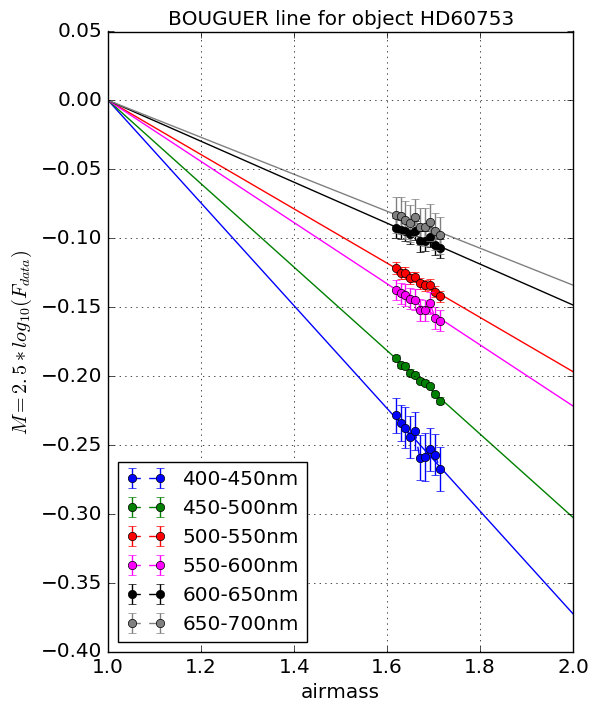

In [272]:
fitparamtruebouguer,popt_truebouguer,perr_truebouguer = ShowTrueBouguer(all_selected_wl,all_selected_dataspectrum,all_airmass)

In [273]:
truncpopt_truebouguer=np.trunc(np.array(popt_truebouguer)*10000)/10000
truncperr_truebouguer=np.trunc(np.array(perr_truebouguer)*10000)/10000

In [274]:
table = ListTable()
table.append(["slope","error"])
for idd in range(0,6):
    table.append([truncpopt_truebouguer[idd][0],truncperr_truebouguer[idd][0]])
table

[['slope', 'error'],
 [-0.37219999999999998, 0.049700000000000001],
 [-0.29759999999999998, 0.0149],
 [-0.1971, 0.014999999999999999],
 [-0.22159999999999999, 0.029000000000000001],
 [-0.1484, 0.0223],
 [-0.1343, 0.0253]]

In [275]:
np.array(popt_truebouguer)[:,0]

array([-0.37229396, -0.29763824, -0.19715473, -0.22169422, -0.14840589,
       -0.13439407])

## Fit Rayleigh Scattering

In [276]:
def FuncRayleigh(x,a):
    return a*(400/x)**4/(1-0.0752*(400./x)**2)

In [277]:
def PlotRayleigh(thepopt,theperr):
    X= [425.,475.,525.,575.,625.,675.]
    Y= np.array(thepopt)[:,0]
    EY=np.array(theperr)[:,0]*10
    
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    ax.errorbar(X,Y,yerr=EY,fmt='o',color='red')
    
    title="Slope of BOUGUER line vs wavelength for object {}".format(object_name)
    ax.set_title(title)
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("slope/airmass (mag)")
    ax.grid(True)
    
    
    popt, pcov = curve_fit(FuncRayleigh,X,Y,sigma=EY)
    perr = np.sqrt(np.diag(pcov))
    xfit=np.linspace(400.,700.0,50)
    yfit=FuncRayleigh(xfit,popt[0])
    plt.plot(xfit,yfit)
    
    figfilename=os.path.join(dir_top_images,'fitrayleighwithbouguer.pdf')
    plt.savefig(figfilename)
    
    print popt[0] ,' at 400 nm'

-0.569702328715  at 400 nm


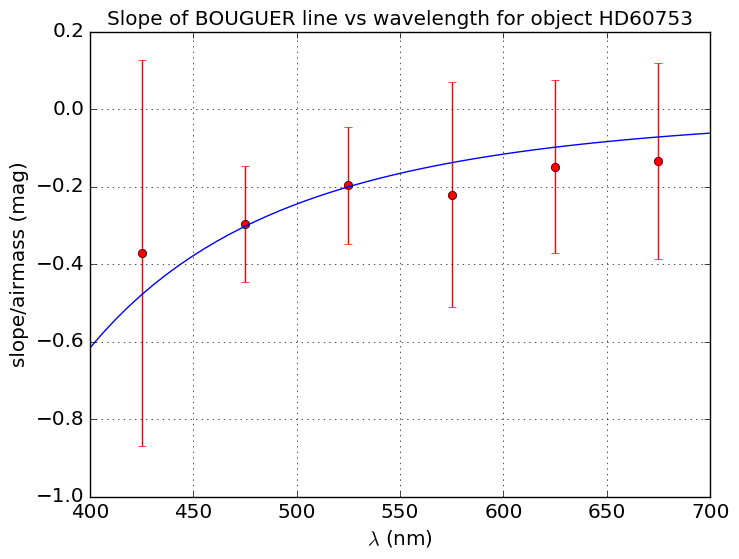

In [278]:
PlotRayleigh(popt_truebouguer,perr_truebouguer)

#### Index airmass min

In [279]:
all_airmass

[1.619, 1.629, 1.639, 1.649, 1.66, 1.67, 1.681, 1.692, 1.703, 1.714]

In [280]:
index_airmassmin=0

In [281]:
def ShowRatioSpectraNorm(idx,thewl,thespectrum,thesimspec,wlcutmin,all_titles,object_name):
    """
    ShowRatioSpectraNorm: Show the calibration curve Normalisation
    ===============================================================
    
    input parameter :
    - idx : the index of minimum airmass
    - thewl : the list of all wavelengths
    - thespectrum : the list of data spectra
    - thesimspec : the list of simulated spectra
    
    output :
    - ratio wavelength collection
    - R ratio collection
    
    """

    
    XMIN=410.
    XMAX=780.
    
    #XMIN=350.
    #XMAX=800.
    
    YMINR=0.7
    YMAXR=1.1

    
    NBSPECTRA=len(thespectrum)
    
    fig, ax = plt.subplots(1, 1, figsize=(15,6))
    
    # check the spectrum used for normalisation 
    #---------------------------------------------
    ratio_sel0=thespectrum[idx]/thesimspec[idx]
    
    
    
    #interpol_ratio=interp1d(all_rightspectra_wl[idx],ratio_sel0)
    interpol_ratio=interp1d(thewl[idx],ratio_sel0)
    
    #wlcutmax=all_rightspectra_wl[idx].max()-1.
    wlcutmin=XMIN
    wlcutmax=XMAX
    
    #selectedindexes0=np.where(np.logical_and(all_rightspectra_wl[idx]>wlcutmin, all_rightspectra_wl[idx]<wlcutmax))     
    selectedindexes0=np.where(np.logical_and(thewl[idx]>wlcutmin, thewl[idx]<wlcutmax))
    
    #sel_wl0=all_rightspectra_wl[idx][selectedindexes0]  # cut wl
    sel_wl0=thewl[idx][selectedindexes0]
    
    ax.plot(sel_wl0, interpol_ratio(sel_wl0),'r-')
    
    ax.grid(True)
    ax.set_xlim(XMIN,XMAX)
    title='Data/Sim spectra ratio at minimum airmass for object {}'.format(object_name)
    
    ax.set_title(title)
    ax.set_ylabel("ratio Data/Sim")
    ax.set_xlabel("$\lambda$ (nm)")
    
    zam_min=all_airmass[idx]
    print 'minimum airmass zmin = ',zam_min
    
    
    # 2nd plot
    #---------
    fig, ax = plt.subplots(1, 1, figsize=(15,8))

    all_ymin= []
    all_ymax=[]
    all_ratioratio=[]
    all_ratiowl=[]
    all_dzam = []
     
    
    for index in np.arange(0,NBSPECTRA):
        
        #print 'spectrum ',index
        ix=index%5
        iy=index/5
        
        zam=all_airmass[index]
        dzam=zam-zam_min  ## relative airmass
        all_dzam.append(dzam)
        
        #selectedindexes=np.where(np.logical_and(all_rightspectra_wl[index]>wlcutmin, all_rightspectra_wl[index]<wlcutmax))     
        selectedindexes=np.where(np.logical_and(thewl[index]>wlcutmin, thewl[index]<wlcutmax))     
        
        sel_data=thespectrum[index][selectedindexes]
        sel_sim=thesimspec[index][selectedindexes]
        sel_wl=thewl[index][selectedindexes]
                
        
        ratio=sel_data/sel_sim
        ratio0=interpol_ratio(sel_wl)
        
        ratioratio=ratio/ratio0
        
        all_ymin.append(ratioratio.min())
        all_ymax.append(ratioratio.max())
        all_ratioratio.append(ratioratio)
        all_ratiowl.append(sel_wl)
           
        if all_expo[index]>0.:    
            ax.plot(sel_wl,ratioratio,'-',lw=2)
       
            ymin=np.array(all_ymin).min() 
            ymax=np.array(all_ymax).max()*1.1   
        
    ax.set_xlim(XMIN,XMAX)
    ax.set_ylim(YMINR,YMAXR)
    
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)
    
    ax.plot([wl_O2Aline,wl_O2Aline],[ymin,ymax],'b-',label='$O_2(A)$',lw=1)
    ax.plot([wl_O2Bline,wl_O2Bline],[ymin,ymax],'b-',label='$O_2(B)$',lw=1)
    ax.plot([wl_Haline,wl_Haline],[ymin,ymax],'r-',label='$H_{alpha}$',lw=1)
    ax.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'g-',label='$H_{beta}$',lw=1)
    ax.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=1)
    ax.plot([wl_Hdline,wl_Hdline],[ymin,ymax],'k-',label='$H_{delta}$',lw=1)
    #ax.legend(loc='best',fontsize=20)
    title='Normalised Data/Sim spectra for object {}'.format(object_name)
    
    ax.set_title(title)
    ax.set_ylabel("ratio")
    ax.set_xlabel("$\lambda$ (nm)")
    
    figfilename=os.path.join(dir_top_images,'DataSimNormDataSimRRatio.pdf')
    
    plt.savefig(figfilename)
    return np.array(all_ratiowl),np.array(all_ratioratio), np.array(all_dzam)
    return all_ratiowl,all_ratioratio, all_dzam


### Return the ratio

minimum airmass zmin =  1.619


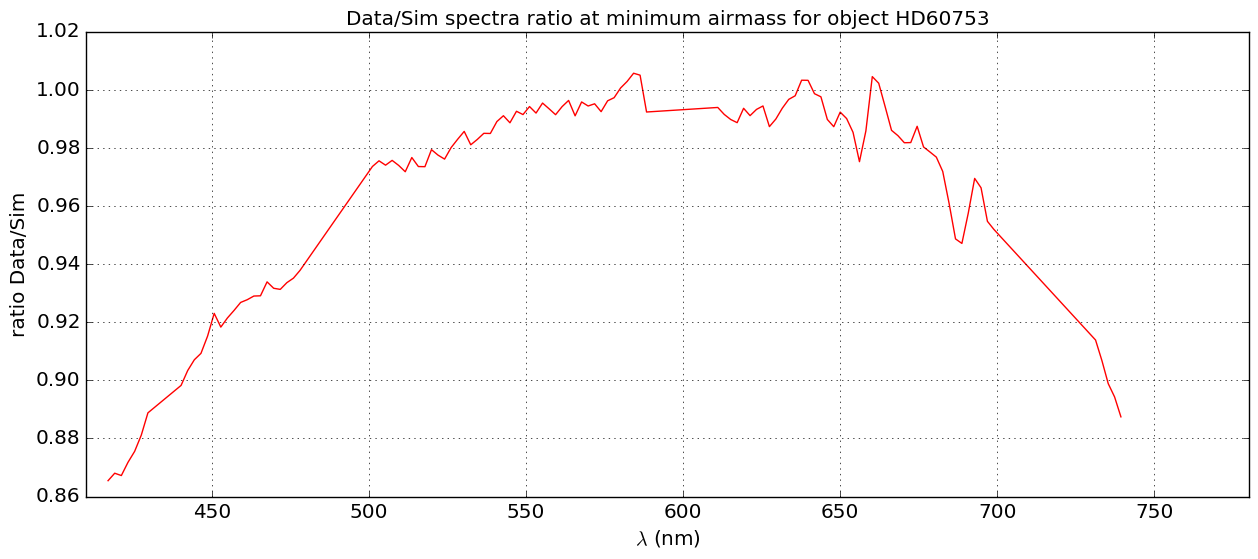

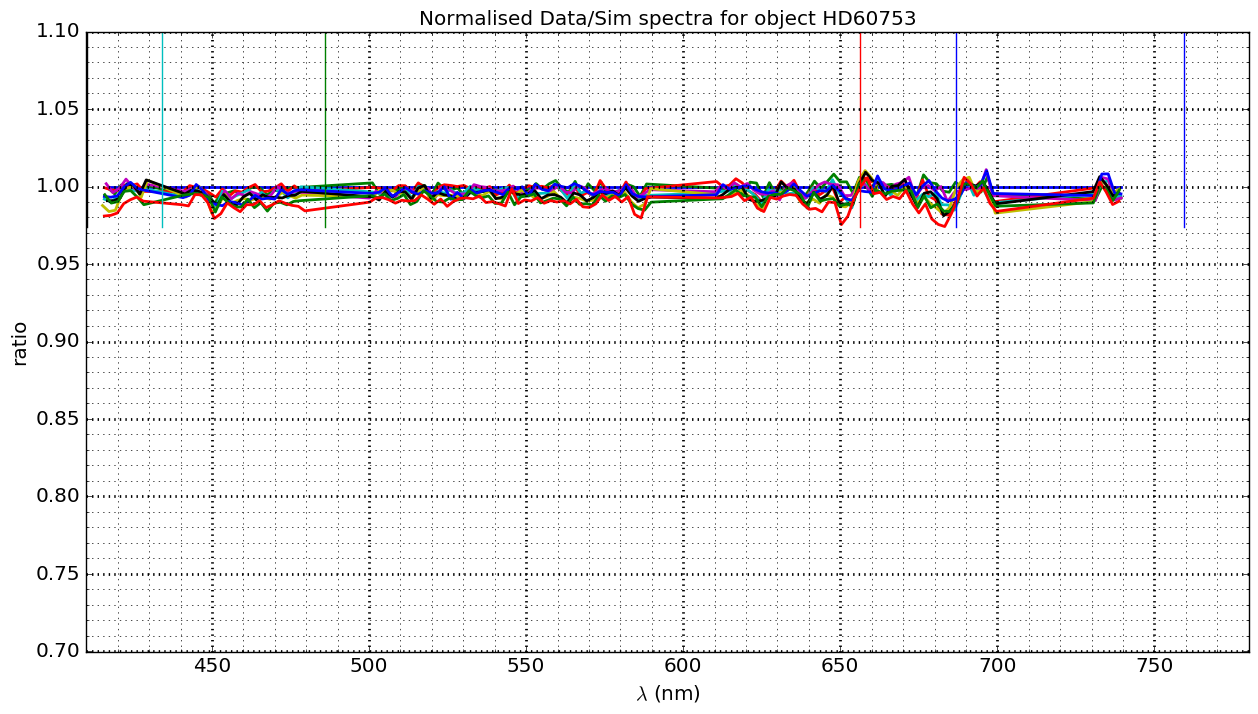

In [282]:
all_ratiowl_cut,all_ratioratio_cut,all_dzam_cut=ShowRatioSpectraNorm(index_airmassmin,all_selected_wl,all_selected_dataspectrum,all_selected_simspectrum,wlcut,all_titles,object_name)

In [283]:
#all_ratiowl_full,all_ratioratio_full,all_dzam_full=ShowRatioSpectraNorm(index_airmassmin,all_rightspectra_wl,all_rightspectra_data,all_rightspectra_sim,wlcut,all_titles,object_name)

## Bouguer Law

In [284]:
def ShowModifBouguer(idxzmin,thewl,theratio,thedzam):
    """
    ShowModifBouguer:
    
    """
    
    fig, ax = plt.subplots(1, 1, figsize=(6,8))
    
    zmin=all_airmass[idxzmin]
    NBBands=6
    labels=["400-450nm", "450-500nm","500-550nm","550-600nm","600-650nm","650-700nm"]
    WLMINAbs=np.array([400.,450.,500.,550,600,650])
    WLMAXAbs=np.array([450.,500.,550.,600,650,700])
    
    NBRATIO=len(theratio)
    
    all_z = []
    all_log10R1vsZ = []
    all_log10R2vsZ = []
    all_log10R3vsZ = []
    all_log10R4vsZ = []
    all_log10R5vsZ = []
    all_log10R6vsZ = []
    all_log10R1vsZE = []
    all_log10R2vsZE = []
    all_log10R3vsZE = []
    all_log10R4vsZE = []
    all_log10R5vsZE = []
    all_log10R6vsZE = []
    
    # loop on ratio
    for index in np.arange(NBRATIO):
        
        if all_expo[index]>0.: 
        
            thez=thedzam[index]+zmin
              
            wl_current=thewl[index]
            wl_ratio=theratio[index]
        
            nbwl=wl_current.shape[0]
        
            band1=np.where(np.logical_and(wl_current>= WLMINAbs[0],wl_current<WLMAXAbs[0]))
            band2=np.where(np.logical_and(wl_current>= WLMINAbs[1],wl_current<WLMAXAbs[1]))    
            band3=np.where(np.logical_and(wl_current>= WLMINAbs[2],wl_current<WLMAXAbs[2])) 
            band4=np.where(np.logical_and(wl_current>= WLMINAbs[3],wl_current<WLMAXAbs[3])) 
            band5=np.where(np.logical_and(wl_current>= WLMINAbs[4],wl_current<WLMAXAbs[4])) 
            band6=np.where(np.logical_and(wl_current>= WLMINAbs[5],wl_current<WLMAXAbs[5])) 
        
            all_R1=wl_ratio[band1]
            all_R2=wl_ratio[band2]
            all_R3=wl_ratio[band3]
            all_R4=wl_ratio[band4]
            all_R5=wl_ratio[band5]
            all_R6=wl_ratio[band6]
        
            all_log10R1 = 2.5*np.log10(all_R1)
            all_log10R2 = 2.5*np.log10(all_R2)
            all_log10R3 = 2.5*np.log10(all_R3)
            all_log10R4 = 2.5*np.log10(all_R4)
            all_log10R5 = 2.5*np.log10(all_R5)
            all_log10R6 = 2.5*np.log10(all_R6)
    
            all_z.append(thez)
            all_log10R1vsZ.append(np.average(all_log10R1))
            all_log10R2vsZ.append(np.average(all_log10R2))
            all_log10R3vsZ.append(np.average(all_log10R3))
            all_log10R4vsZ.append(np.average(all_log10R4))
            all_log10R5vsZ.append(np.average(all_log10R5))
            all_log10R6vsZ.append(np.average(all_log10R6))
            
            all_log10R1vsZE.append(np.std(all_log10R1)/np.sqrt(all_log10R1.shape[0]))
            all_log10R2vsZE.append(np.std(all_log10R2)/np.sqrt(all_log10R2.shape[0]))
            all_log10R3vsZE.append(np.std(all_log10R3)/np.sqrt(all_log10R3.shape[0]))
            all_log10R4vsZE.append(np.std(all_log10R4)/np.sqrt(all_log10R4.shape[0]))
            all_log10R5vsZE.append(np.std(all_log10R5)/np.sqrt(all_log10R5.shape[0]))
            all_log10R6vsZE.append(np.std(all_log10R6)/np.sqrt(all_log10R6.shape[0]))
        
    ax.errorbar(all_z,all_log10R1vsZ,yerr=all_log10R1vsZE,fmt='--o',color='blue',label=labels[0])
    ax.errorbar(all_z,all_log10R2vsZ,yerr=all_log10R2vsZE,fmt='--o',color='green',label=labels[1])
    ax.errorbar(all_z,all_log10R3vsZ,yerr=all_log10R3vsZE,fmt='--o',color='red',label=labels[2])
    ax.errorbar(all_z,all_log10R4vsZ,yerr=all_log10R4vsZE,fmt='--o',color='magenta',label=labels[3])
    ax.errorbar(all_z,all_log10R5vsZ,yerr=all_log10R5vsZE,fmt='--o',color='black',label=labels[4])
    ax.errorbar(all_z,all_log10R6vsZ,yerr=all_log10R6vsZE,fmt='--o',color='grey',label=labels[5])  
    
    #ax.plot(all_z,all_log10R1vsZ,'o-',label=labels[0])
    #ax.plot(all_z,all_log10R2vsZ,'o-',label=labels[1])
    #ax.plot(all_z,all_log10R3vsZ,'o-',label=labels[2])
    #ax.plot(all_z,all_log10R4vsZ,'o-',label=labels[3])
    #ax.plot(all_z,all_log10R5vsZ,'o-',label=labels[4])
    #ax.plot(all_z,all_log10R6vsZ,'o-',label=labels[5])
    
    ax.grid(True)
    #ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.grid(b=True, which='major', colo1r='k', linewidth=2.0)
    #ax.grid(b=True, which='minor', color='k', linewidth=0.5) 
    title="Modified BOUGUER line for object {}".format(object_name)
    ax.set_title(title)
    ax.set_xlabel("airmass")
    ax.set_ylabel("$\Delta M=2.5*log_{10}(R)=2.5*log_{10}(F_{data}/F_{sim})$ (mag)")
    ax.legend(loc="best")
    figfilename=os.path.join(dir_top_images,'modified_bouguerE1.pdf')
    plt.savefig(figfilename)
    

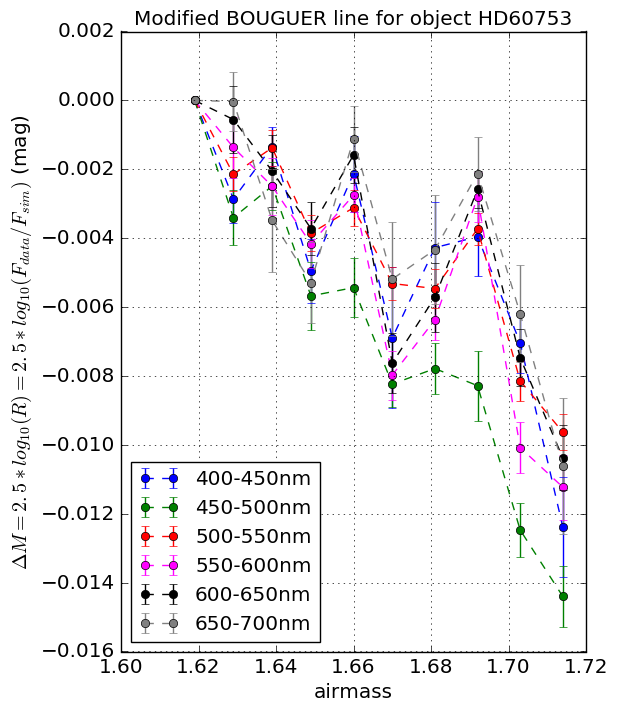

In [285]:
ShowModifBouguer(index_airmassmin,all_ratiowl_cut,all_ratioratio_cut,all_dzam_cut)

In [286]:
def ShowModifBouguer2(idxzmin,thewl,theratio,thedzam):
    """
    ShowModifBouguer2:
    
    """
    
    fig, ax = plt.subplots(1, 1, figsize=(6,8))
    
    zmin=all_airmass[idxzmin]
    NBBands=6
    labels=["400-450nm", "450-500nm","500-550nm","550-600nm","600-650nm","650-700nm"]
    WLMINAbs=np.array([400.,450.,500.,550,600,650])
    WLMAXAbs=np.array([450.,500.,550.,600,650,700])
    
    NBRATIO=len(theratio)
    
    all_z = []
    all_log10R1vsZ = []
    all_log10R2vsZ = []
    all_log10R3vsZ = []
    all_log10R4vsZ = []
    all_log10R5vsZ = []
    all_log10R6vsZ = []
    
    all_log10R1vsZE = []
    all_log10R2vsZE = []
    all_log10R3vsZE = []
    all_log10R4vsZE = []
    all_log10R5vsZE = []
    all_log10R6vsZE = []
    
    # loop on ratio
    for index in np.arange(NBRATIO):
        
        if all_expo[index]>0.: 
        
            thez=thedzam[index]+zmin
              
            wl_current=thewl[index]
            wl_ratio=theratio[index]
        
            nbwl=wl_current.shape[0]
        
            band1=np.where(np.logical_and(wl_current>= WLMINAbs[0],wl_current<WLMAXAbs[0]))
            band2=np.where(np.logical_and(wl_current>= WLMINAbs[1],wl_current<WLMAXAbs[1]))    
            band3=np.where(np.logical_and(wl_current>= WLMINAbs[2],wl_current<WLMAXAbs[2])) 
            band4=np.where(np.logical_and(wl_current>= WLMINAbs[3],wl_current<WLMAXAbs[3])) 
            band5=np.where(np.logical_and(wl_current>= WLMINAbs[4],wl_current<WLMAXAbs[4])) 
            band6=np.where(np.logical_and(wl_current>= WLMINAbs[5],wl_current<WLMAXAbs[5])) 
        
            all_R1=wl_ratio[band1]
            all_R2=wl_ratio[band2]
            all_R3=wl_ratio[band3]
            all_R4=wl_ratio[band4]
            all_R5=wl_ratio[band5]
            all_R6=wl_ratio[band6]
        
            all_log10R1 = 2.5*np.log10(all_R1)
            all_log10R2 = 2.5*np.log10(all_R2)
            all_log10R3 = 2.5*np.log10(all_R3)
            all_log10R4 = 2.5*np.log10(all_R4)
            all_log10R5 = 2.5*np.log10(all_R5)
            all_log10R6 = 2.5*np.log10(all_R6)
    
            all_z.append(thez)
            all_log10R1vsZ.append(np.average(all_log10R1))
            all_log10R2vsZ.append(np.average(all_log10R2))
            all_log10R3vsZ.append(np.average(all_log10R3))
            all_log10R4vsZ.append(np.average(all_log10R4))
            all_log10R5vsZ.append(np.average(all_log10R5))
            all_log10R6vsZ.append(np.average(all_log10R6))
            
            all_log10R1vsZE.append(np.std(all_log10R1))
            all_log10R2vsZE.append(np.std(all_log10R2))
            all_log10R3vsZE.append(np.std(all_log10R3))
            all_log10R4vsZE.append(np.std(all_log10R4))
            all_log10R5vsZE.append(np.std(all_log10R5))
            all_log10R6vsZE.append(np.std(all_log10R6))
        
        
    ax.errorbar(all_z,all_log10R1vsZ,yerr=all_log10R1vsZE,fmt='--o',color='blue',label=labels[0])
    ax.errorbar(all_z,all_log10R2vsZ,yerr=all_log10R2vsZE,fmt='--o',color='green',label=labels[1])
    ax.errorbar(all_z,all_log10R3vsZ,yerr=all_log10R3vsZE,fmt='--o',color='red',label=labels[2])
    ax.errorbar(all_z,all_log10R4vsZ,yerr=all_log10R4vsZE,fmt='--o',color='magenta',label=labels[3])
    ax.errorbar(all_z,all_log10R5vsZ,yerr=all_log10R5vsZE,fmt='--o',color='black',label=labels[4])
    ax.errorbar(all_z,all_log10R6vsZ,yerr=all_log10R6vsZE,fmt='--o',color='grey',label=labels[5])
    #ax.plot(all_z,all_log10R2vsZ,'o-',label=labels[1])
    #ax.plot(all_z,all_log10R3vsZ,'o-',label=labels[2])
    #ax.plot(all_z,all_log10R4vsZ,'o-',label=labels[3])
    #ax.plot(all_z,all_log10R5vsZ,'o-',label=labels[4])
    #ax.plot(all_z,all_log10R6vsZ,'o-',label=labels[5])
    
    ax.grid(True)
    #ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.grid(b=True, which='major', colo1r='k', linewidth=2.0)
    #ax.grid(b=True, which='minor', color='k', linewidth=0.5) 
    title="Modified BOUGUER curve for object {}".format(object_name)
    ax.set_title(title)
    ax.set_xlabel("airmass")
    ax.set_ylabel("$\Delta M=2.5*log_{10}(R)=2.5*log_{10}(F_{data}/F_{sim})$ (mag)")
    ax.legend(loc="best")
    figfilename=os.path.join(dir_top_images,'modified_bouguerE2.pdf')
    plt.savefig(figfilename)
    

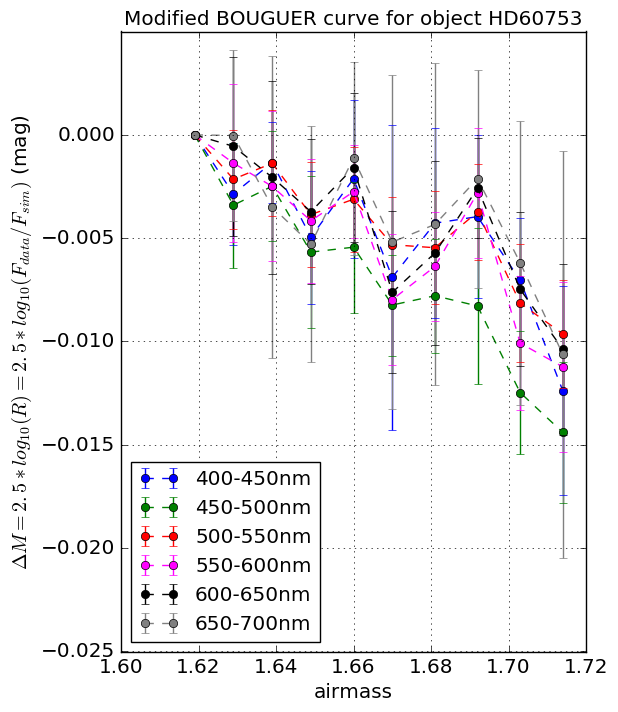

In [287]:
ShowModifBouguer2(index_airmassmin,all_ratiowl_cut,all_ratioratio_cut,all_dzam_cut)

In [288]:
def SimpleLinearFitBouguer(idxzmin,thewl,theratio,thedzam):
    """
    FitBouguer:
    
    """
    
    ZCUT=1.66
    
    fig, ax = plt.subplots(1, 1, figsize=(6,8))
    
    zmin=all_airmass[idxzmin]
    
    NBBands=6
    labels=["400-450nm", "450-500nm","500-550nm","550-600nm","600-650nm","650-700nm"]
    WLMINAbs=np.array([400.,450.,500.,550,600,650])
    WLMAXAbs=np.array([450.,500.,550.,600,650,700])
    
    NBRATIO=len(theratio)
    
    all_z1 = []
    all_log10R1vsZ1 = []
    all_log10R2vsZ1 = []
    all_log10R3vsZ1 = []
    all_log10R4vsZ1 = []
    all_log10R5vsZ1 = []
    all_log10R6vsZ1 = []
    
    all_z2 = []
    all_log10R1vsZ2 = []
    all_log10R2vsZ2 = []
    all_log10R3vsZ2 = []
    all_log10R4vsZ2 = []
    all_log10R5vsZ2 = []
    all_log10R6vsZ2 = []
    
    fitparam1 = []
    fitparam2 = []
    y1fit = []
    y2fit = []
    x1fit=np.linspace(1.,ZCUT,50)
    x2fit=np.linspace(ZCUT,2.0,50)
    # loop on ratio
    #---------------
    for index in np.arange(NBRATIO):
        
        if all_expo[index]>0.: 
        
            thez=thedzam[index]+zmin
              
            wl_current=thewl[index]
            wl_ratio=theratio[index]
        
            nbwl=wl_current.shape[0]
        
            band1=np.where(np.logical_and(wl_current>= WLMINAbs[0],wl_current<WLMAXAbs[0]))
            band2=np.where(np.logical_and(wl_current>= WLMINAbs[1],wl_current<WLMAXAbs[1]))    
            band3=np.where(np.logical_and(wl_current>= WLMINAbs[2],wl_current<WLMAXAbs[2])) 
            band4=np.where(np.logical_and(wl_current>= WLMINAbs[3],wl_current<WLMAXAbs[3])) 
            band5=np.where(np.logical_and(wl_current>= WLMINAbs[4],wl_current<WLMAXAbs[4])) 
            band6=np.where(np.logical_and(wl_current>= WLMINAbs[5],wl_current<WLMAXAbs[5])) 
                
            all_R1=wl_ratio[band1]
            all_R2=wl_ratio[band2]
            all_R3=wl_ratio[band3]
            all_R4=wl_ratio[band4]
            all_R5=wl_ratio[band5]
            all_R6=wl_ratio[band6]
            
            all_log10R1 = 2.5*np.log10(all_R1)
            all_log10R2 = 2.5*np.log10(all_R2)
            all_log10R3 = 2.5*np.log10(all_R3)
            all_log10R4 = 2.5*np.log10(all_R4)
            all_log10R5 = 2.5*np.log10(all_R5)
            all_log10R6 = 2.5*np.log10(all_R6)
            
            if(thez<=ZCUT):  
                all_z1.append(thez)
                all_log10R1vsZ1.append(np.average(all_log10R1))
                all_log10R2vsZ1.append(np.average(all_log10R2))
                all_log10R3vsZ1.append(np.average(all_log10R3))
                all_log10R4vsZ1.append(np.average(all_log10R4))
                all_log10R5vsZ1.append(np.average(all_log10R5))
                all_log10R6vsZ1.append(np.average(all_log10R6))
            else:
                all_z2.append(thez)
                all_log10R1vsZ2.append(np.average(all_log10R1))
                all_log10R2vsZ2.append(np.average(all_log10R2))
                all_log10R3vsZ2.append(np.average(all_log10R3))
                all_log10R4vsZ2.append(np.average(all_log10R4))
                all_log10R5vsZ2.append(np.average(all_log10R5))
                all_log10R6vsZ2.append(np.average(all_log10R6))
    
    
    x1=np.array(all_z1) 
    
    for iband in np.arange(NBBands):
        if iband==0:
            y=np.array(all_log10R1vsZ1)
        elif iband ==1:
            y=np.array(all_log10R2vsZ1)
        elif iband==2:
            y=np.array(all_log10R3vsZ1)
        elif iband ==3:
            y=np.array(all_log10R4vsZ1) 
        elif iband==4:
            y=np.array(all_log10R5vsZ1)
        elif iband ==5:
            y=np.array(all_log10R6vsZ1) 
            
        z1 = np.polyfit(x1, y, 1)
        fitparam1.append(z1)    
        p1 = np.poly1d(z1)
        yfit=p1(x1fit)
        y1fit.append(yfit)
        
    x2=np.array(all_z2)
    
    for iband in np.arange(NBBands):
        if iband==0:
            y=np.array(all_log10R1vsZ2)
        elif iband ==1:
            y=np.array(all_log10R2vsZ2)
        elif iband==2:
            y=np.array(all_log10R3vsZ2)
        elif iband ==3:
            y=np.array(all_log10R4vsZ2) 
        elif iband==4:
            y=np.array(all_log10R5vsZ2)
        elif iband ==5:
            y=np.array(all_log10R6vsZ2)            
        z2 = np.polyfit(x2, y, 1)
        fitparam2.append(z2)    
        p2 = np.poly1d(z2)
        yfit=p2(x2fit)
        y2fit.append(yfit)
                
    xfit=np.append(x1fit,x2fit)
    
    yfit=np.append(y1fit[0],y2fit[0])
    yfit=yfit-yfit[0] 
    ax.plot(xfit,yfit,'b-',lw=2,label=labels[0])
    
     
    yfit=np.append(y1fit[1],y2fit[1])
    yfit=yfit-yfit[1] 
    ax.plot(xfit,yfit,'r-',lw=2,label=labels[1])
    
    yfit=np.append(y1fit[2],y2fit[2])
    yfit=yfit-yfit[2] 
    ax.plot(xfit,yfit,'g-',lw=2,label=labels[2])
    
    yfit=np.append(y1fit[3],y2fit[3])
    yfit=yfit-yfit[3] 
    ax.plot(xfit,yfit,'k-',lw=2,label=labels[3])
    
    yfit=np.append(y1fit[4],y2fit[4])
    yfit=yfit-yfit[4] 
    ax.plot(xfit,yfit,'c-',lw=2,label=labels[4])
    
    yfit=np.append(y1fit[5],y2fit[5])
    yfit=yfit-yfit[5] 
    ax.plot(xfit,yfit,'y-',lw=2,label=labels[5])
    
    
    #ax.plot(xfit,np.append(y1fit[1],y2fit[1]),'r-',lw=2,label=labels[1])
    #ax.plot(xfit,np.append(y1fit[2],y2fit[2]),'g-',lw=2,label=labels[2])
    #ax.plot(xfit,np.append(y1fit[3],y2fit[3]),'k-',lw=2,label=labels[3])
    #ax.plot(xfit,np.append(y1fit[4],y2fit[4]),'c-',lw=2,label=labels[4])
    #ax.plot(xfit,np.append(y1fit[5],y2fit[5]),'y-',lw=2,label=labels[5])
    
    
    #ax.plot(xfit,y1fit[2],'g-',label=labels[2])
    #ax.plot(xfit,y1fit[3],'k-',label=labels[3])
    #ax.plot(xfit,y1fit[4],'c-',label=labels[4])
    #ax.plot(xfit,y1fit[5],'y-',label=labels[5])
    
    #ax.plot(x2fit,y2fit[0],'b-')
    #ax.plot(x2fit,y2fit[1],'r-')
    #ax.plot(x2fit,y2fit[2],'g-')
    #ax.plot(x2fit,y2fit[3],'k-')
    #ax.plot(x2fit,y2fit[4],'c-')
    #ax.plot(x2fit,y2fit[5],'y-')
    
    
    ax.grid(True)
    #ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    
    #ax.grid(b=True, which='major', colo1r='k', linewidth=2.0)
    #ax.grid(b=True, which='minor', color='k', linewidth=0.5) 
    title="Simple Fit BOUGUER lines for object {}".format(object_name)
    ax.set_title(title)
    ax.set_xlabel("airmass")
    ax.set_ylabel("$\Delta M=2.5*log_{10}(R)=2.5*log_{10}(F_{data}/F_{sim})$ (mag)")
    ax.legend(loc="best")
    figfilename=os.path.join(dir_top_images,'fitbougher1.pdf')
    plt.savefig(figfilename)
    return np.array(fitparam1),np.array(fitparam2)
    

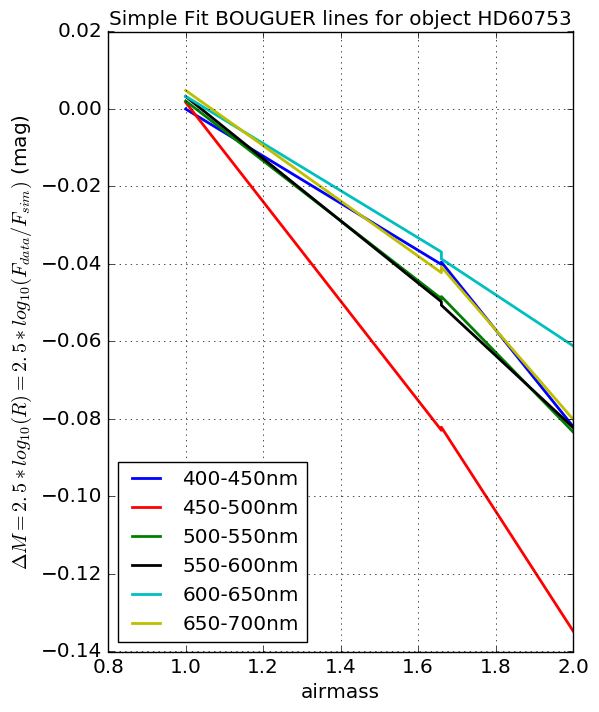

In [289]:
fitparam1_cut,fitparam2_cut=SimpleLinearFitBouguer(index_airmassmin,all_ratiowl_cut,all_ratioratio_cut,all_dzam_cut)

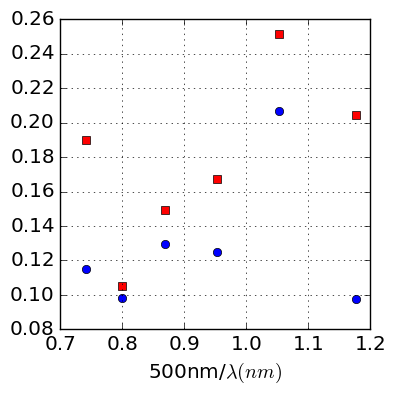

In [290]:
WLarr=np.array([425.,475.,525.,575.,625.,675.])
plt.plot(500/WLarr,fitparam1_cut[:,1] ,'o',color='blue')
plt.plot(500/WLarr,fitparam2_cut[:,1] ,'s',color='red')
plt.grid(True)
plt.xlabel("500nm/$\lambda (nm)$")

In [291]:
# import numpy.polynomial.polynomial.polyfit as polyfitw

In [292]:
from scipy.optimize import curve_fit

In [293]:
#def bougline(x, a, b):
#    return a*x + b

In [294]:
def FitABouguerLine(thex,they,theey):
    
    x=np.copy(thex)
    y=np.copy(they)
    ey=np.copy(theey)
    z = np.polyfit(x,y, 1)    
    popt, pcov = curve_fit(bougline,x,y,p0=z,sigma=ey)
    perr = np.sqrt(np.diag(pcov))
    return popt,perr

In [295]:
def FitBouguer2(idxzmin,thewl,theratio,thedzam):
    """
    FitBouguer2:
    
    """
    
    ZCUT=1.66
    
    fig, ax = plt.subplots(1, 1, figsize=(6,8))
    
    zmin=all_airmass[idxzmin]
    NBBands=6
    labels=["400-450nm", "450-500nm","500-550nm","550-600nm","600-650nm","650-700nm"]
    WLMINAbs=np.array([400.,450.,500.,550,600,650])
    WLMAXAbs=np.array([450.,500.,550.,600,650,700])
    
    NBRATIO=len(theratio)
    
    all_z = []
    all_log10R1vsZ = []
    all_log10R2vsZ = []
    all_log10R3vsZ = []
    all_log10R4vsZ = []
    all_log10R5vsZ = []
    all_log10R6vsZ = []
    
    all_log10R1vsZE = []
    all_log10R2vsZE = []
    all_log10R3vsZE = []
    all_log10R4vsZE = []
    all_log10R5vsZE = []
    all_log10R6vsZE = []
    
    
    all_z1 = []
    all_log10R1vsZ1 = []
    all_log10R2vsZ1 = []
    all_log10R3vsZ1 = []
    all_log10R4vsZ1 = []
    all_log10R5vsZ1 = []
    all_log10R6vsZ1 = []
    
    all_log10R1vsZ1E = []
    all_log10R2vsZ1E = []
    all_log10R3vsZ1E = []
    all_log10R4vsZ1E = []
    all_log10R5vsZ1E = []
    all_log10R6vsZ1E = []
    
    
    all_z2 = []
    all_log10R1vsZ2 = []
    all_log10R2vsZ2 = []
    all_log10R3vsZ2 = []
    all_log10R4vsZ2 = []
    all_log10R5vsZ2 = []
    all_log10R6vsZ2 = []
    
    all_log10R1vsZ2E = []
    all_log10R2vsZ2E = []
    all_log10R3vsZ2E = []
    all_log10R4vsZ2E = []
    all_log10R5vsZ2E = []
    all_log10R6vsZ2E = []
    
    fitparam1 = []
    fitparam2 = []
    
    x1fit=np.linspace(1.,ZCUT,50)
    x2fit=np.linspace(ZCUT,2.0,50)
    
    
    # loop on ratio to compute arerage and error points, that is to say, on the airmass z
    for index in np.arange(NBRATIO):
        
        if all_expo[index]>0: 
        
            thez=thedzam[index]+zmin
            
           
              
            wl_current=thewl[index]
            wl_ratio=theratio[index]
        
            nbwl=wl_current.shape[0]
        
            band1=np.where(np.logical_and(wl_current>= WLMINAbs[0],wl_current<WLMAXAbs[0]))
            band2=np.where(np.logical_and(wl_current>= WLMINAbs[1],wl_current<WLMAXAbs[1]))    
            band3=np.where(np.logical_and(wl_current>= WLMINAbs[2],wl_current<WLMAXAbs[2])) 
            band4=np.where(np.logical_and(wl_current>= WLMINAbs[3],wl_current<WLMAXAbs[3])) 
            band5=np.where(np.logical_and(wl_current>= WLMINAbs[4],wl_current<WLMAXAbs[4])) 
            band6=np.where(np.logical_and(wl_current>= WLMINAbs[5],wl_current<WLMAXAbs[5])) 
        
            all_R1=wl_ratio[band1]
            all_R2=wl_ratio[band2]
            all_R3=wl_ratio[band3]
            all_R4=wl_ratio[band4]
            all_R5=wl_ratio[band5]
            all_R6=wl_ratio[band6]
        
            all_log10R1 = 2.5*np.log10(all_R1)
            all_log10R2 = 2.5*np.log10(all_R2)
            all_log10R3 = 2.5*np.log10(all_R3)
            all_log10R4 = 2.5*np.log10(all_R4)
            all_log10R5 = 2.5*np.log10(all_R5)
            all_log10R6 = 2.5*np.log10(all_R6)
    
            all_z.append(thez)
            all_log10R1vsZ.append(np.average(all_log10R1))
            all_log10R2vsZ.append(np.average(all_log10R2))
            all_log10R3vsZ.append(np.average(all_log10R3))
            all_log10R4vsZ.append(np.average(all_log10R4))
            all_log10R5vsZ.append(np.average(all_log10R5))
            all_log10R6vsZ.append(np.average(all_log10R6))
            
            all_log10R1vsZE.append(np.std(all_log10R1)/np.sqrt(all_log10R1.shape[0]))
            all_log10R2vsZE.append(np.std(all_log10R2)/np.sqrt(all_log10R2.shape[0]))
            all_log10R3vsZE.append(np.std(all_log10R3)/np.sqrt(all_log10R3.shape[0]))
            all_log10R4vsZE.append(np.std(all_log10R4)/np.sqrt(all_log10R4.shape[0]))
            all_log10R5vsZE.append(np.std(all_log10R5)/np.sqrt(all_log10R5.shape[0]))
            all_log10R6vsZE.append(np.std(all_log10R6)/np.sqrt(all_log10R6.shape[0]))
            
           
            # separate according the conditions depending on Z
            #--------------------------------------------------
            if thez<=ZCUT:  
                all_z1.append(thez)
                all_log10R1vsZ1.append(np.average(all_log10R1))
                all_log10R2vsZ1.append(np.average(all_log10R2))
                all_log10R3vsZ1.append(np.average(all_log10R3))
                all_log10R4vsZ1.append(np.average(all_log10R4))
                all_log10R5vsZ1.append(np.average(all_log10R5))
                all_log10R6vsZ1.append(np.average(all_log10R6))
                
                all_log10R1vsZ1E.append(np.std(all_log10R1)/np.sqrt(all_log10R1.shape[0]))
                all_log10R2vsZ1E.append(np.std(all_log10R2)/np.sqrt(all_log10R2.shape[0]))
                all_log10R3vsZ1E.append(np.std(all_log10R3)/np.sqrt(all_log10R3.shape[0]))
                all_log10R4vsZ1E.append(np.std(all_log10R4)/np.sqrt(all_log10R4.shape[0]))
                all_log10R5vsZ1E.append(np.std(all_log10R5)/np.sqrt(all_log10R5.shape[0]))
                all_log10R6vsZ1E.append(np.std(all_log10R6)/np.sqrt(all_log10R6.shape[0]))
            else:
                all_z2.append(thez)
                all_log10R1vsZ2.append(np.average(all_log10R1))
                all_log10R2vsZ2.append(np.average(all_log10R2))
                all_log10R3vsZ2.append(np.average(all_log10R3))
                all_log10R4vsZ2.append(np.average(all_log10R4))
                all_log10R5vsZ2.append(np.average(all_log10R5))
                all_log10R6vsZ2.append(np.average(all_log10R6))
                
                all_log10R1vsZ2E.append(np.std(all_log10R1)/np.sqrt(all_log10R1.shape[0]))
                all_log10R2vsZ2E.append(np.std(all_log10R2)/np.sqrt(all_log10R2.shape[0]))
                all_log10R3vsZ2E.append(np.std(all_log10R3)/np.sqrt(all_log10R3.shape[0]))
                all_log10R4vsZ2E.append(np.std(all_log10R4)/np.sqrt(all_log10R4.shape[0]))
                all_log10R5vsZ2E.append(np.std(all_log10R5)/np.sqrt(all_log10R5.shape[0]))
                all_log10R6vsZ2E.append(np.std(all_log10R6)/np.sqrt(all_log10R6.shape[0]))
            
   
    
    # plot the points    
    ax.errorbar(all_z,all_log10R1vsZ,yerr=all_log10R1vsZE,fmt='o',color='blue',label=labels[0])
    ax.errorbar(all_z,all_log10R2vsZ,yerr=all_log10R2vsZE,fmt='o',color='green',label=labels[1])
    ax.errorbar(all_z,all_log10R3vsZ,yerr=all_log10R3vsZE,fmt='o',color='red',label=labels[2])
    ax.errorbar(all_z,all_log10R4vsZ,yerr=all_log10R4vsZE,fmt='o',color='magenta',label=labels[3])
    ax.errorbar(all_z,all_log10R5vsZ,yerr=all_log10R5vsZE,fmt='o',color='black',label=labels[4])
    ax.errorbar(all_z,all_log10R6vsZ,yerr=all_log10R6vsZE,fmt='o',color='grey',label=labels[5])
    
    
    
    ## Now does the fit for z<ZCUT
    
    all_z1=np.array(all_z1)
    all_z2=np.array(all_z2)
    all_log10R1vsZ1=np.array(all_log10R1vsZ1)
    all_log10R2vsZ1=np.array(all_log10R2vsZ1)
    all_log10R3vsZ1=np.array(all_log10R3vsZ1)
    all_log10R4vsZ1=np.array(all_log10R4vsZ1)
    all_log10R5vsZ1=np.array(all_log10R5vsZ1)
    all_log10R6vsZ1=np.array(all_log10R6vsZ1)
    
    all_log10R1vsZ1E=np.array(all_log10R1vsZ1E)
    all_log10R2vsZ1E=np.array(all_log10R2vsZ1E)
    all_log10R3vsZ1E=np.array(all_log10R3vsZ1E)
    all_log10R4vsZ1E=np.array(all_log10R4vsZ1E)
    all_log10R5vsZ1E=np.array(all_log10R5vsZ1E)
    all_log10R6vsZ1E=np.array(all_log10R6vsZ1E)
    
    
    popt,perr=FitABouguerLine(all_z1,all_log10R1vsZ1,all_log10R1vsZ1E)
    pol = np.poly1d(popt)
    y1fit=pol(x1fit)
    plt.plot(x1fit,y1fit,'b-',lw=2)
    
    popt,perr=FitABouguerLine(all_z1,all_log10R2vsZ1,all_log10R2vsZ1E)
    pol = np.poly1d(popt)
    y1fit=pol(x1fit)
    plt.plot(x1fit,y1fit,'g-',lw=2)
   
    
    popt,perr=FitABouguerLine(all_z1,all_log10R3vsZ1,all_log10R3vsZ1E)
    pol = np.poly1d(popt)
    y1fit=pol(x1fit)
    plt.plot(x1fit,y1fit,'r-',lw=2)
    
    popt,perr=FitABouguerLine(all_z1,all_log10R4vsZ1,all_log10R4vsZ1E)
    pol = np.poly1d(popt)
    y1fit=pol(x1fit)
    plt.plot(x1fit,y1fit,'m-',lw=2)
    
    popt,perr=FitABouguerLine(all_z1,all_log10R5vsZ1,all_log10R5vsZ1E)
    pol = np.poly1d(popt)
    y1fit=pol(x1fit)
    plt.plot(x1fit,y1fit,'k-',lw=2)
    
    popt,perr=FitABouguerLine(all_z1,all_log10R6vsZ1,all_log10R6vsZ1E)
    pol = np.poly1d(popt)
    y1fit=pol(x1fit)
    plt.plot(x1fit,y1fit,'-',color='grey',lw=2)
        
    popt,perr=FitABouguerLine(all_z2,all_log10R1vsZ2,all_log10R1vsZ2E)
    pol = np.poly1d(popt)
    y2fit=pol(x2fit)
    plt.plot(x2fit,y2fit,'b-',lw=2)
    
    popt,perr=FitABouguerLine(all_z2,all_log10R2vsZ2,all_log10R2vsZ2E)
    pol = np.poly1d(popt)
    y2fit=pol(x2fit)
    plt.plot(x2fit,y2fit,'g-',lw=2)
    
    popt,perr=FitABouguerLine(all_z2,all_log10R3vsZ2,all_log10R3vsZ2E)
    pol = np.poly1d(popt)
    y2fit=pol(x2fit)
    plt.plot(x2fit,y2fit,'r-',lw=2)
    
    popt,perr=FitABouguerLine(all_z2,all_log10R4vsZ2,all_log10R4vsZ2E)
    pol = np.poly1d(popt)
    y2fit=pol(x2fit)
    plt.plot(x2fit,y2fit,'m-',lw=2)
    
    popt,perr=FitABouguerLine(all_z2,all_log10R5vsZ2,all_log10R5vsZ2E)
    pol = np.poly1d(popt)
    y2fit=pol(x2fit)
    plt.plot(x2fit,y2fit,'k-',lw=2)
    
    popt,perr=FitABouguerLine(all_z2,all_log10R6vsZ2,all_log10R6vsZ2E)
    pol = np.poly1d(popt)
    y2fit=pol(x2fit)
    plt.plot(x2fit,y2fit,'-',color='grey',lw=2)
    
    
    
    ax.grid(True)
    #ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.grid(b=True, which='major', colo1r='k', linewidth=2.0)
    #ax.grid(b=True, which='minor', color='k', linewidth=0.5) 
    title="Modified BOUGUER line for object {}".format(object_name)
    ax.set_title(title)
    #ax.set_xlim(1.3,2)
    ax.set_xlabel("airmass")
    ax.set_ylabel("$\Delta M=2.5*log_{10}(R)=2.5*log_{10}(F_{data}/F_{sim})$ (mag)")
    ax.legend(loc="best")
    figfilename=os.path.join(dir_top_images,'modified_fitbougherE1.pdf')
    plt.savefig(figfilename)
    

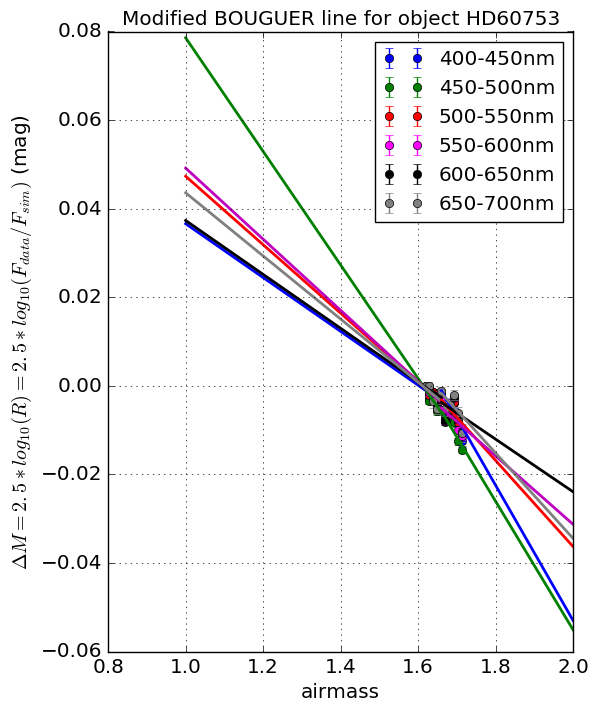

In [296]:
FitBouguer2(index_airmassmin,all_ratiowl_cut,all_ratioratio_cut,all_dzam_cut)

## Fit Ratio

In [297]:
def FitRatio(all_ratiowl,all_ratioratio,all_dzam,figtitle='Normalised Data/Sim spectra for object {}'):
    NBRATIO=len(all_ratioratio)
    
    XMIN=400.
    XMAX=740.
    YMAX=1.1
    YMIN=0.7
    
    xfit=np.linspace(XMIN,XMAX,50)
    
    fitparam= []
    
    fig, ax = plt.subplots(1, 1, figsize=(15,8))
    
    for index in np.arange(NBRATIO):
        dz=all_dzam[index]
        
        if all_expo[index]>0 and dz>0 : 
            x=all_ratiowl[index]
            y=all_ratioratio[index]
            z = np.polyfit(x, y, 1)
            fitparam.append(z)
        
            p = np.poly1d(z)
            yfit=p(xfit)
        
           
            ax.plot(xfit,yfit,'-',lw=1)
            
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)        
            
    ax.set_ylim(YMIN,YMAX)        
            
    title=figtitle.format(object_name)
    ax.set_title(title)
    ax.set_ylabel("ratio")
    ax.set_xlabel("$\lambda$ (nm)")
    
    figfilename=os.path.join(dir_top_images,'FitLinearDataSimNormDataSimRRatio.pdf')
    plt.savefig(figfilename)
    
    return np.array(fitparam)

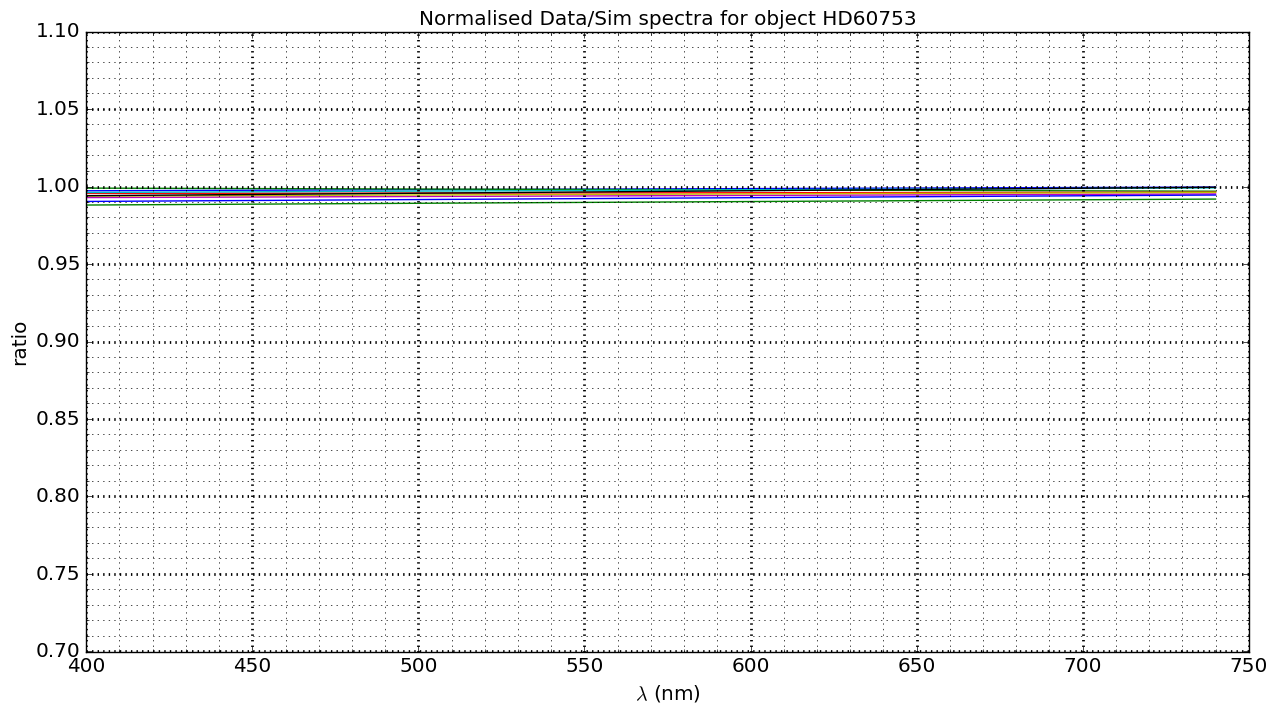

In [298]:
fitparam_cut=FitRatio(all_ratiowl_cut,all_ratioratio_cut,all_dzam_cut)

# New U ratio
================

## Definition of U ratio
=============================
$$
U(\lambda, z-z_{min}) = \frac{ \frac{T_{data}(z)}{T_{sim}(z)}}{ \frac{T_{data}(z_{min})}{T_{sim}(z_{min})}}= 
\exp \left( (z-z_{min}) \times \left(\tau_v^{gray}+ \tau_v^{aer}(\lambda_0/\lambda)^\alpha \right) \right)
$$


by calculating the following ratio $W(\lambda)$
$$
W(\lambda) = \frac{- \ln R(\lambda,z-z_{min})}{(z-z_{min})} = \tau_v^{gray}+ \tau_v^{aer}(\lambda_0/\lambda)^\alpha 
$$


From the series of images, we calculate $W(\lambda)$

### find the correspondence airmass-index

In [299]:
NBAIRMASS=len(all_airmass)
zipped=zip(range(NBAIRMASS),all_airmass)
print zipped

[(0, 1.619), (1, 1.629), (2, 1.639), (3, 1.649), (4, 1.66), (5, 1.67), (6, 1.681), (7, 1.692), (8, 1.703), (9, 1.714)]


### defines the range where to compute the ratio ratio

In [300]:
idxnorm1=0
idxstart1=1
idxstop1=9

idxnorm2=0
idxstart2=1
idxstop2=9

In [301]:
def ExtractURatioSpectraNorm(idxnorm,idxstart,idxstop,thewl,thespectrum,thesimspec,wlcutmin,all_titles,object_name):
    """
    ExtractURatioSpectraNorm: Show the calibration curve Normalisation
    ===============================================================
    
    input parameter :
    - idxnorm : the index of minimum airmass
    - idxstart : index to start the airmass loop
    - idxstop : index for stopping the airmass loop
    - thewl : the list of all wavelengths
    - thespectrum : the list of data spectra
    - thesimspec : the list of simulated spectra
    
    output :
    - ratio wavelength collection
    - R ratio collection
    
    """

    
    XMIN=410.
    XMAX=780.
  
    
    YMINR=0.7
    YMAXR=1.1

    
    NBSPECTRA=len(thespectrum)
    
    fig, ax = plt.subplots(1, 1, figsize=(15,6))
    
    # check the spectrum used for normalisation 
    #---------------------------------------------
    ratio_sel0=thespectrum[idxnorm]/thesimspec[idxnorm]
    
    
   
    interpol_ratio=interp1d(thewl[idxnorm],ratio_sel0)
    
    
    wlcutmin=XMIN
    wlcutmax=XMAX
    
        
    selectedindexes0=np.where(np.logical_and(thewl[idxnorm]>wlcutmin, thewl[idxnorm]<wlcutmax))
   
    sel_wl0=thewl[idxnorm][selectedindexes0]
    
    ax.plot(sel_wl0, interpol_ratio(sel_wl0),'r-')
    
    ax.grid(True)
    ax.set_xlim(XMIN,XMAX)
    title='Data/Sim spectra ratio at minimum airmass for object {}'.format(object_name)
    
    ax.set_title(title)
    ax.set_ylabel("ratio Data/Sim")
    ax.set_xlabel("$\lambda$ (nm)")
    
    zam_min=all_airmass[idxnorm]
    print 'minimum airmass zmin = ',zam_min
    
    
    # 2nd plot
    #---------
    fig, ax = plt.subplots(1, 1, figsize=(15,8))

    all_ymin= []
    all_ymax=[]
    all_ratioratio=[]
    all_ratiowl=[]
    all_dzam = []
     
    
    #for index in np.arange(0,NBSPECTRA):
    for fullindex in np.arange(idxstart,idxstop+1):    
        
        index=fullindex-idxstart
        
        #print 'spectrum ',index
        ix=index%5
        iy=index/5
        
        # the current airmass
        zam=all_airmass[fullindex]
        
        dzam=zam-zam_min  ## relative airmass
        all_dzam.append(dzam)
        
        # select the ratio in the appropriate WL range
        selectedindexes=np.where(np.logical_and(thewl[fullindex]>wlcutmin, thewl[fullindex]<wlcutmax))     
        
        sel_data=thespectrum[fullindex][selectedindexes]
        sel_sim=thesimspec[fullindex][selectedindexes]
        sel_wl=thewl[fullindex][selectedindexes]
                
        
        ratio=sel_data/sel_sim
        ratio0=interpol_ratio(sel_wl)
        
        ratioratio=ratio/ratio0
        
        all_ymin.append(ratioratio.min())
        all_ymax.append(ratioratio.max())
        all_ratioratio.append(ratioratio)
        all_ratiowl.append(sel_wl)
           
        if all_expo[fullindex]>0:    ## Should always be the case now
            ax.plot(sel_wl,ratioratio,'-',lw=2)
       
            ymin=np.array(all_ymin).min() 
            ymax=np.array(all_ymax).max()*1.1   
        
    ax.set_xlim(XMIN,XMAX)
    ax.set_ylim(YMINR,YMAXR)
    
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)
    
    ax.plot([wl_O2Aline,wl_O2Aline],[ymin,ymax],'b-',label='$O_2(A)$',lw=1)
    ax.plot([wl_O2Bline,wl_O2Bline],[ymin,ymax],'b-',label='$O_2(B)$',lw=1)
    ax.plot([wl_Haline,wl_Haline],[ymin,ymax],'r-',label='$H_{alpha}$',lw=1)
    ax.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'g-',label='$H_{beta}$',lw=1)
    ax.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=1)
    ax.plot([wl_Hdline,wl_Hdline],[ymin,ymax],'k-',label='$H_{delta}$',lw=1)
    #ax.legend(loc='best',fontsize=20)
    title='Normalised Data/Sim spectra U ratio for object {}'.format(object_name)
    
    ax.set_title(title)
    ax.set_ylabel("ratio")
    ax.set_xlabel("$\lambda$ (nm)")
    
    figfilename=os.path.join(dir_top_images,'DataSimNormDataSimURatio.pdf')
    
    plt.savefig(figfilename)
    return np.array(all_ratiowl),np.array(all_ratioratio), np.array(all_dzam)
    return all_ratiowl,all_ratioratio, all_dzam



minimum airmass zmin =  1.619


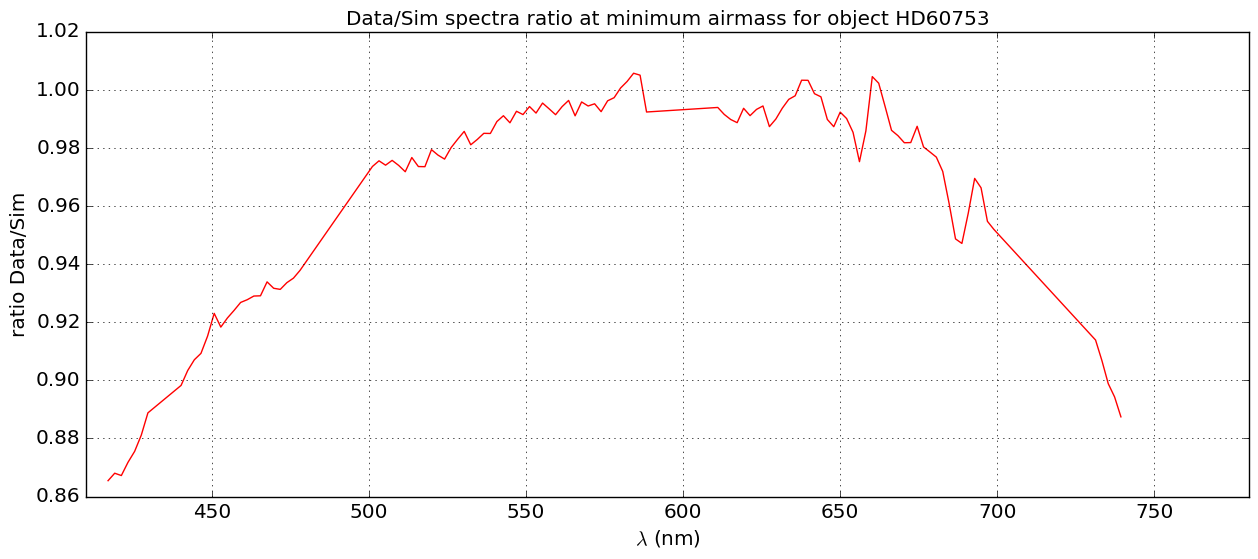

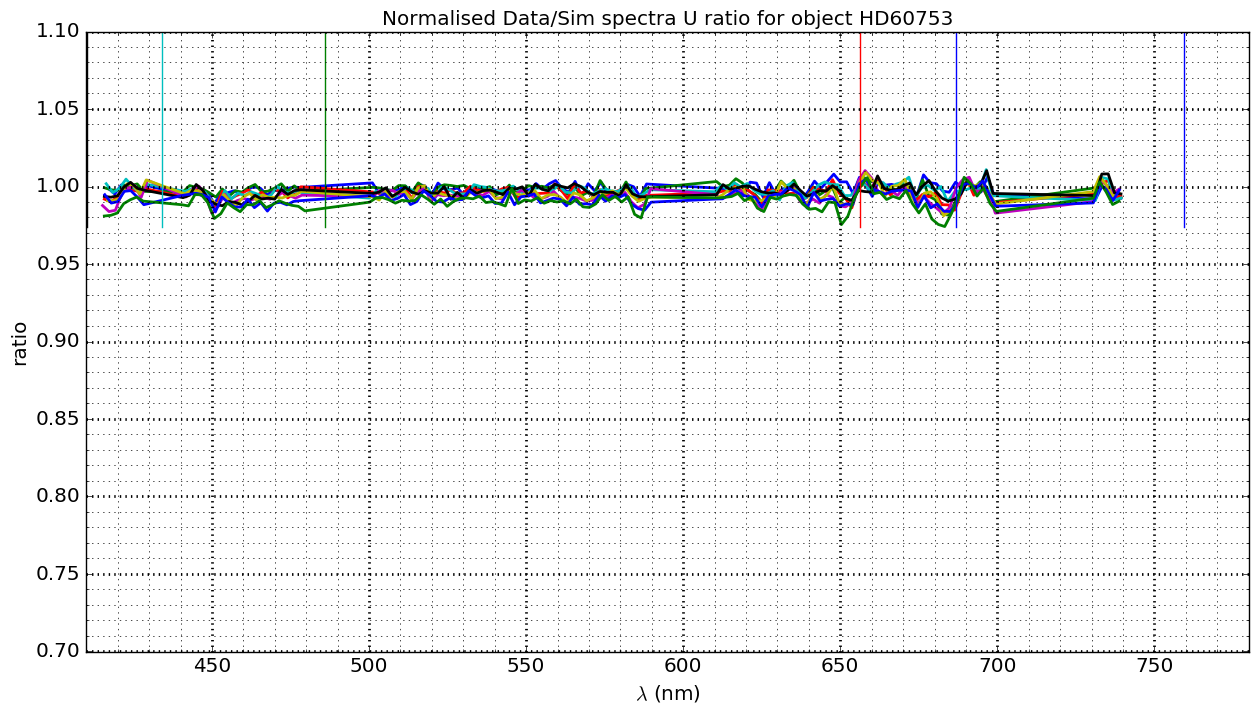

In [302]:
all_ratiowl_cut1,all_ratioratio_cut1,all_dzam_cut1=ExtractURatioSpectraNorm(idxnorm1,idxstart1,idxstop1,all_selected_wl,all_selected_dataspectrum,all_selected_simspectrum,wlcut,all_titles,object_name)

minimum airmass zmin =  1.619


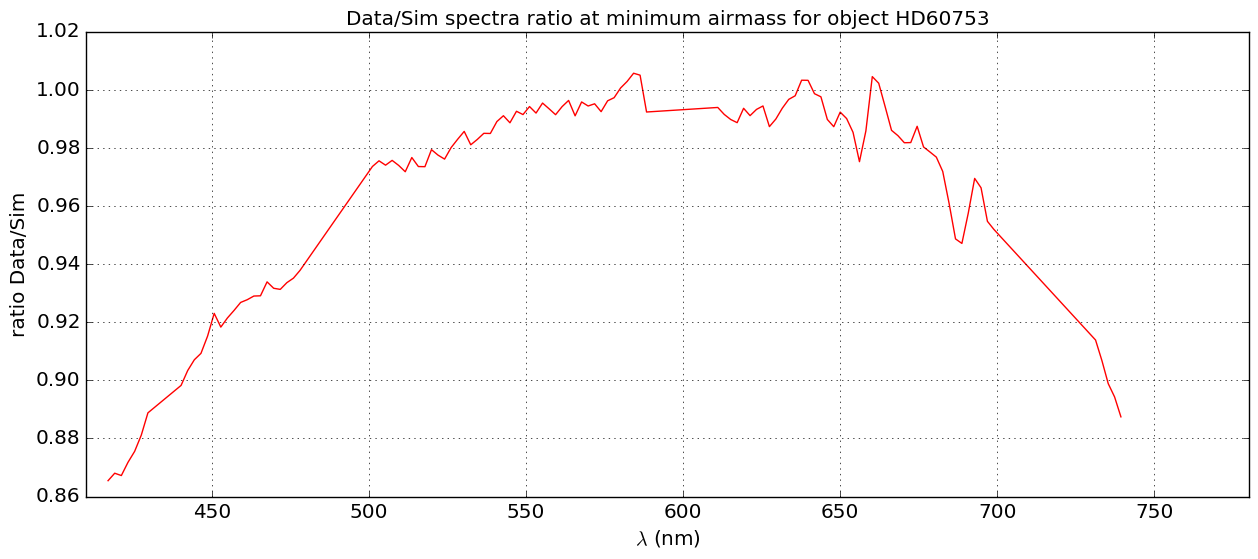

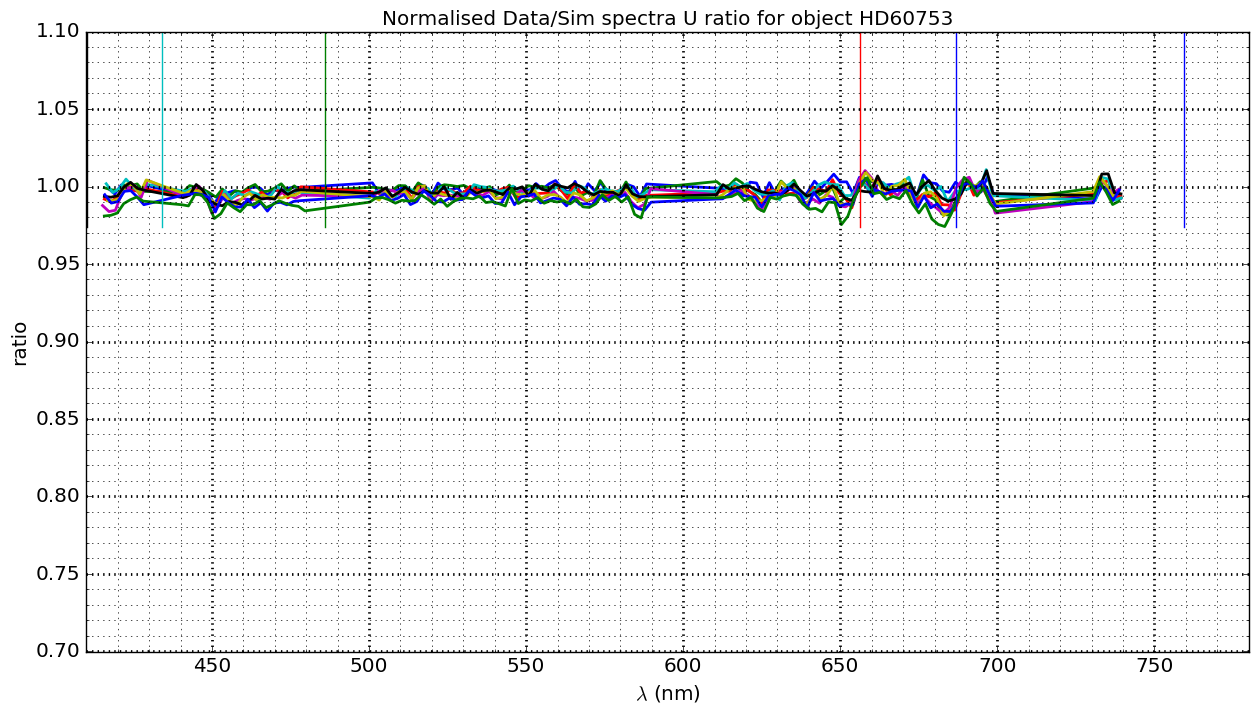

In [303]:
all_ratiowl_cut2,all_ratioratio_cut2,all_dzam_cut2=ExtractURatioSpectraNorm(idxnorm2,idxstart2,idxstop2,all_selected_wl,all_selected_dataspectrum,all_selected_simspectrum,wlcut,all_titles,object_name)

In [304]:
def PlotExtinction1(all_ratiowl,all_ratioratio,all_dzam,figtitle='U ratio for object {}'):
    """
    Extinction versus lambda
    
    """
    NBRATIO=len(all_ratioratio)
    
    XMIN=400.
    XMAX=740.
    YMAX=3
    YMIN=-3

    
    fig, ax = plt.subplots(1, 1, figsize=(15,8))
    
    for index in np.arange(NBRATIO):
        dzam=all_dzam[index]
        if dzam != 0 and all_expo[index] !=0  :      
            x=all_ratiowl[index]
            y=-np.log(all_ratioratio[index])/dzam
            ax.plot(x,y,'o',lw=2)
        
        
            
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)        
            
    ax.set_ylim(YMIN,YMAX)        
            
    title=figtitle.format(object_name)
    ax.set_title(title)
    ax.set_ylabel(" U ratio")
    ax.set_xlabel("$\lambda$ (nm)")
    
    figfilename=os.path.join(dir_top_images,'Extinction1_Uratio.pdf')
    plt.savefig(figfilename)
   

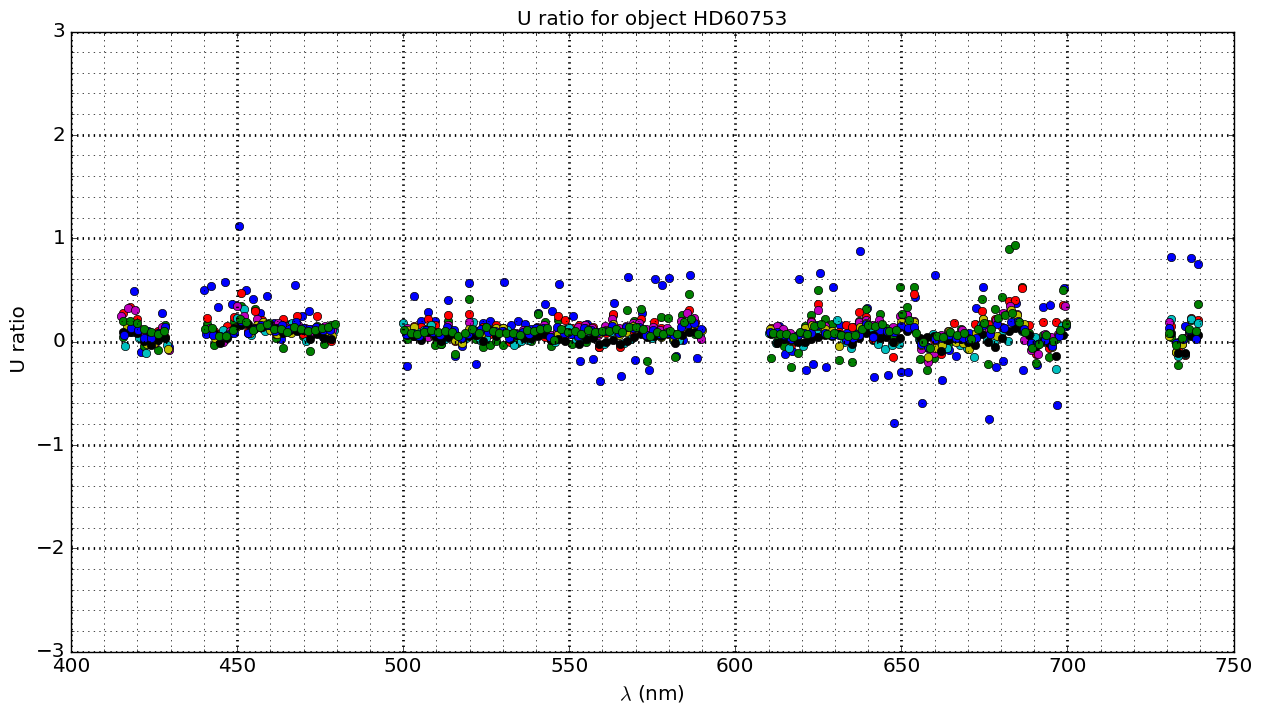

In [305]:
PlotExtinction1(all_ratiowl_cut1,all_ratioratio_cut1,all_dzam_cut1)

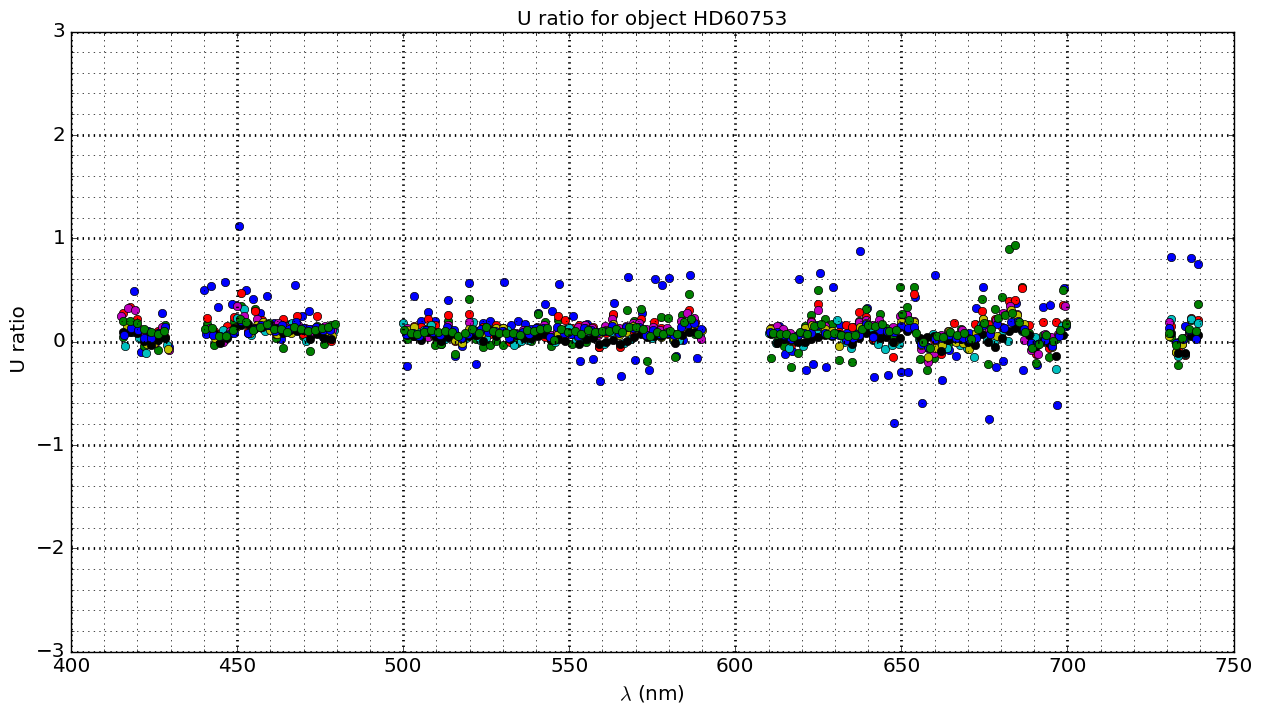

In [306]:
PlotExtinction1(all_ratiowl_cut2,all_ratioratio_cut2,all_dzam_cut2)

In [307]:
def PlotExtinction2(all_ratiowl,all_ratioratio,all_dzam,figtitle='U ratio for object {}'):
    """
    Extinction versus 1/lambda
    
    """
    NBRATIO=len(all_ratioratio)
    
    XMIN=400.
    XMAX=740.
    YMAX=3
    YMIN=-3

    
    fig, ax = plt.subplots(1, 1, figsize=(15,8))
    
    for index in np.arange(NBRATIO):
        dzam=all_dzam[index]
        if dzam != 0 and all_expo[index] !=0  :      
            x=500./all_ratiowl[index]
            y=-np.log(all_ratioratio[index])/dzam
            ax.plot(x,y,'o',lw=2)
        
        
            
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)        
            
    ax.set_ylim(YMIN,YMAX)        
            
    title=figtitle.format(object_name)
    ax.set_title(title)
    ax.set_ylabel(" U ratio")
    ax.set_xlabel("$500nm/\lambda$ (nm)")
   
    figfilename=os.path.join(dir_top_images,'Extinction2_Uratio.pdf')
    plt.savefig(figfilename)
    

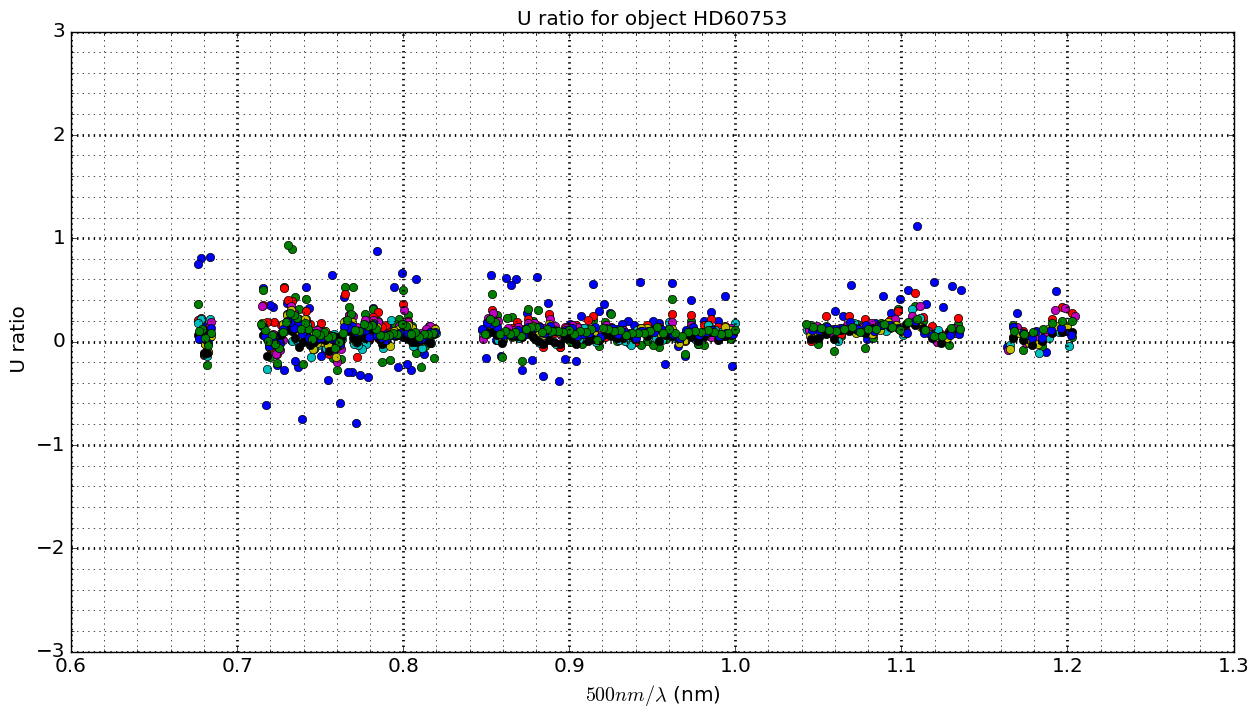

In [308]:
PlotExtinction2(all_ratiowl_cut1,all_ratioratio_cut1,all_dzam_cut1)

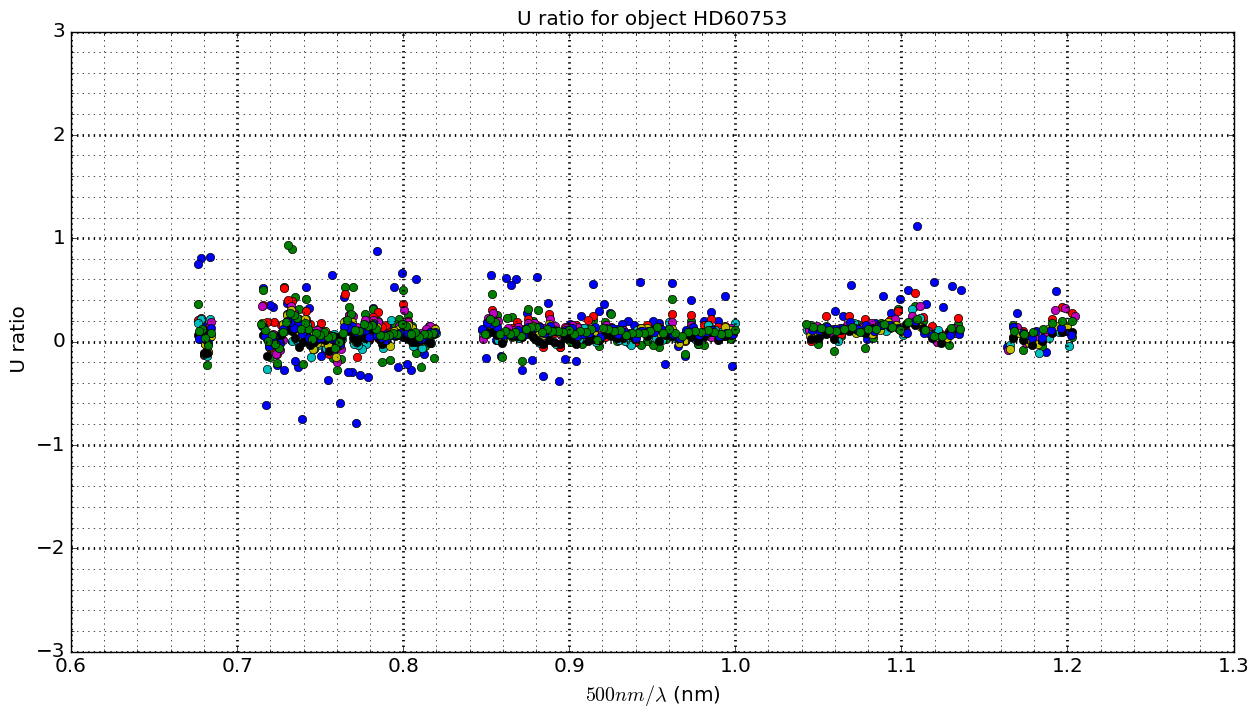

In [309]:
PlotExtinction2(all_ratiowl_cut2,all_ratioratio_cut2,all_dzam_cut2)

### Linear fit of extinction

In [310]:
def LinearFitExtinction(all_ratiowl,all_ratioratio,all_dzam,figtitle=' Fit U ratio for object {}'):
   
    NBRATIOS=len(all_ratioratio)
    
    print "NBRATIOS =",NBRATIOS
    
    XMIN=0.65
    XMAX=1.3
    YMAX=1
    YMIN=-1

    xfit=np.linspace(XMIN,XMAX,50)
    
    fitparam= []
    all_dzrel= []
    
    fig, ax = plt.subplots(1, 1, figsize=(15,8))
    
    for index in np.arange(NBRATIOS):
        dzam=all_dzam[index]
        if dzam != 0 and all_expo[index]>0  : 
            all_dzrel.append(dzam)
            x=500./all_ratiowl[index]
            y=-np.log(all_ratioratio[index])/dzam
                        
            z = np.polyfit(x, y, 1)
            fitparam.append(z)
        
            p = np.poly1d(z)
            yfit=p(xfit)
         
            ax.plot(xfit,yfit,'-',lw=1)        
        
            
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)        
            
    ax.set_ylim(YMIN,YMAX)        
            
    title=figtitle.format(object_name)
    ax.set_title(title)
    ax.set_ylabel(" U ratio")
    ax.set_xlabel("$500nm/\lambda$ (nm)")
   
    figfilename=os.path.join(dir_top_images,'FitLinearExtinction2_Uratio.pdf')
    plt.savefig(figfilename)
    
        
    return np.array(fitparam), all_dzrel
        

NBRATIOS = 9


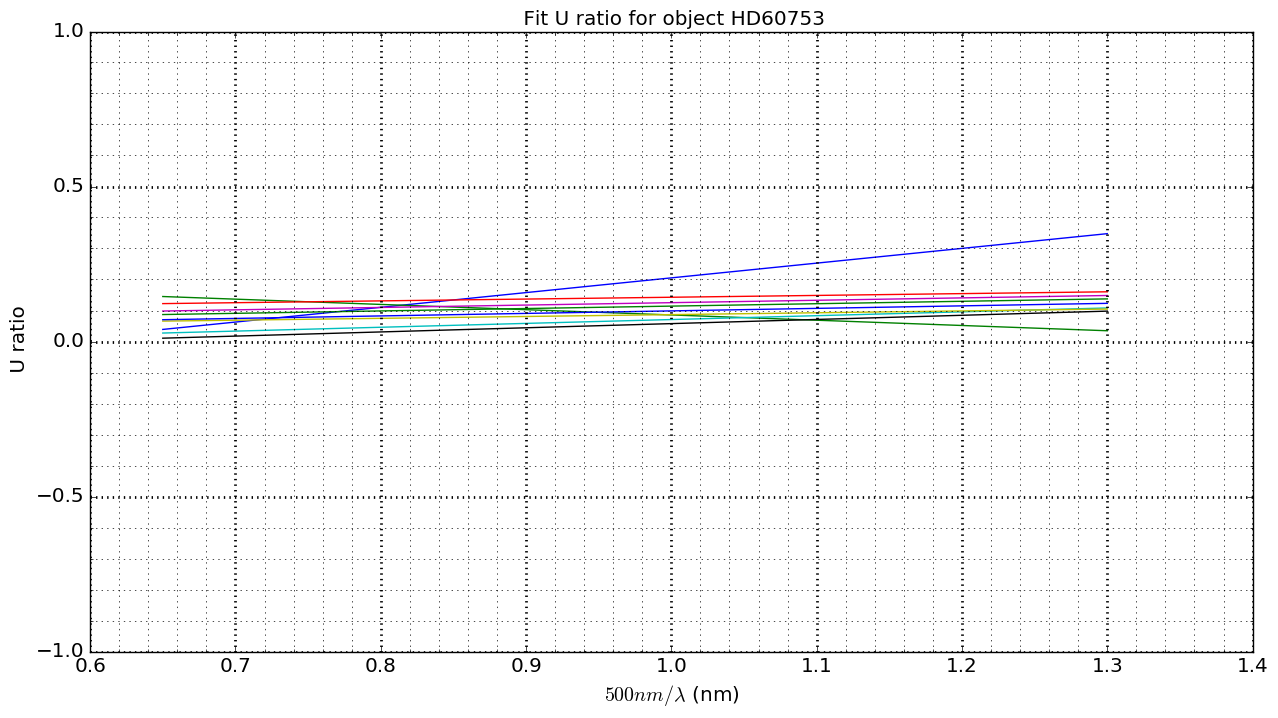

In [311]:
fitparam_cut1,all_dzrel_cut1=LinearFitExtinction(all_ratiowl_cut1,all_ratioratio_cut1,all_dzam_cut1)

NBRATIOS = 9


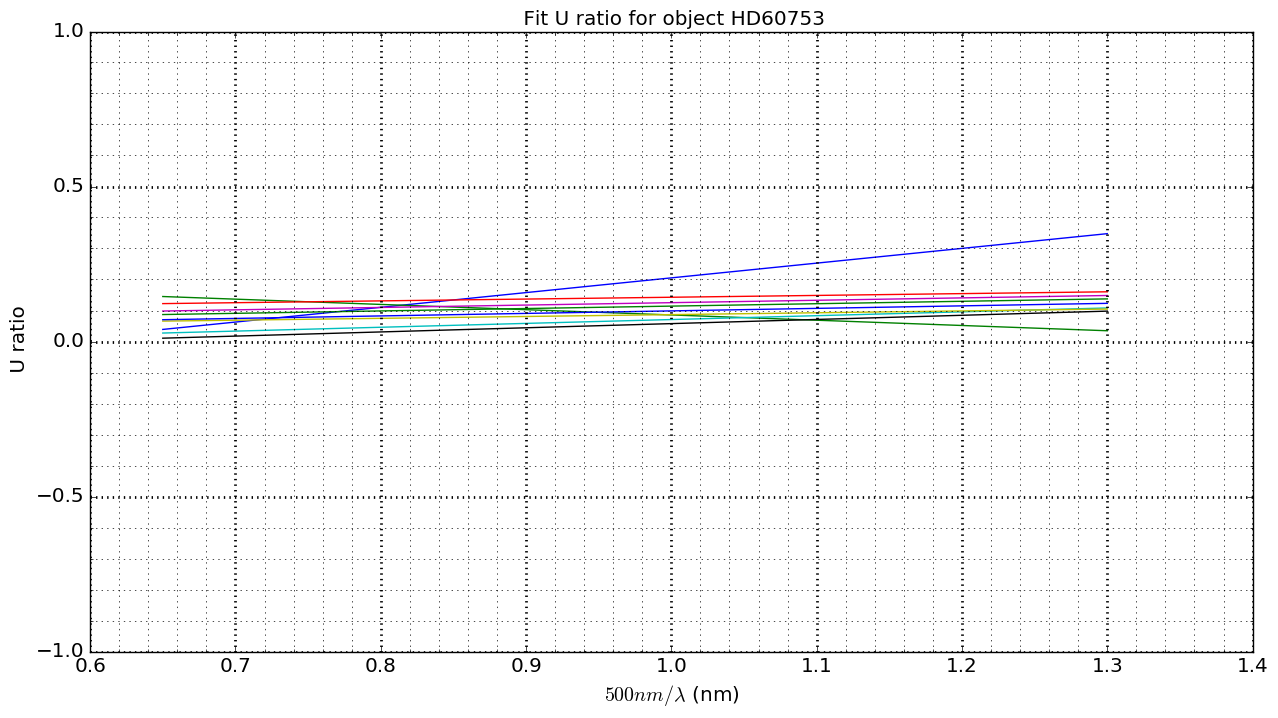

In [312]:
fitparam_cut2,all_dzrel_cut2=LinearFitExtinction(all_ratiowl_cut2,all_ratioratio_cut2,all_dzam_cut2)

### Non linear fit of extinction

In [313]:
from scipy.optimize import curve_fit

In [314]:
def extinct(x, a, b,c):
    return a + b * x**c

In [315]:
def FitExtinct(thex,they):
    x=np.copy(thex)
    y=np.copy(they)
    z = np.polyfit(x,y, 1)
    z=np.append(z,1.)
    popt, pcov = curve_fit(extinct,x,y,p0=z)
    perr = np.sqrt(np.diag(pcov))
    return popt,perr

In [316]:
def NonLinearFitExtinction1(all_ratiowl,all_ratioratio,all_dzam,figtitle=' Fit W ratio for object {}'):
    NBRATIO=len(all_ratioratio)
    
    XMIN=0.65
    XMAX=1.3
    YMAX=0.5
    YMIN=-0.2

    xfit=np.linspace(XMIN,XMAX,50)
    
    fitoptparam= []
    fitperr= []
    fitchi2=[]
    all_dzrel= []
    
    fig, ax = plt.subplots(1, 1, figsize=(15,8))
    
    for index in np.arange(NBRATIO):
        dzam=all_dzam[index]
        if dzam != 0 and all_expo[index]>0  : 
            all_dzrel.append(dzam)
            x=500./all_ratiowl[index]
            y=-np.log(all_ratioratio[index])/dzam   ### Here divide by dzam to remove airmass dependence
            
            popt, perr = FitExtinct(x, y)
            chi2_vector=(y-extinct(x,popt[0],popt[1],popt[2]))**2
            chi2=np.average(chi2_vector)
            
            #print '------------------------------------'
            #print "a =", popt[0], "+/-", pcov[0,0]**0.5
            #print "b =", popt[1], "+/-", pcov[1,1]**0.5
            #print "c =", popt[2], "+/-", pcov[2,2]**0.5
            #print "chi2 =", chi2
                       
        
            fitoptparam.append(popt)  
            fitperr.append(perr)
            fitchi2.append(chi2)
            
            yfit=extinct(xfit,popt[0],popt[1],popt[2])
         
            if chi2 <0.003:              
                ax.plot(x,y,'o')
                ax.plot(xfit,yfit,'-',lw=2) 
            
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)        
            
    ax.set_ylim(YMIN,YMAX)        
            
    title=figtitle.format(object_name)
    ax.set_title(title)
    ax.set_ylabel(" W ratio")
    ax.set_xlabel("$500/\lambda$ (nm)")
    
    figfilename=os.path.join(dir_top_images,'FitNonLinearExtinction1_Uratio.pdf')
    plt.savefig(figfilename)
   
        
    return np.array(fitoptparam), all_dzrel, fitperr,fitchi2
        

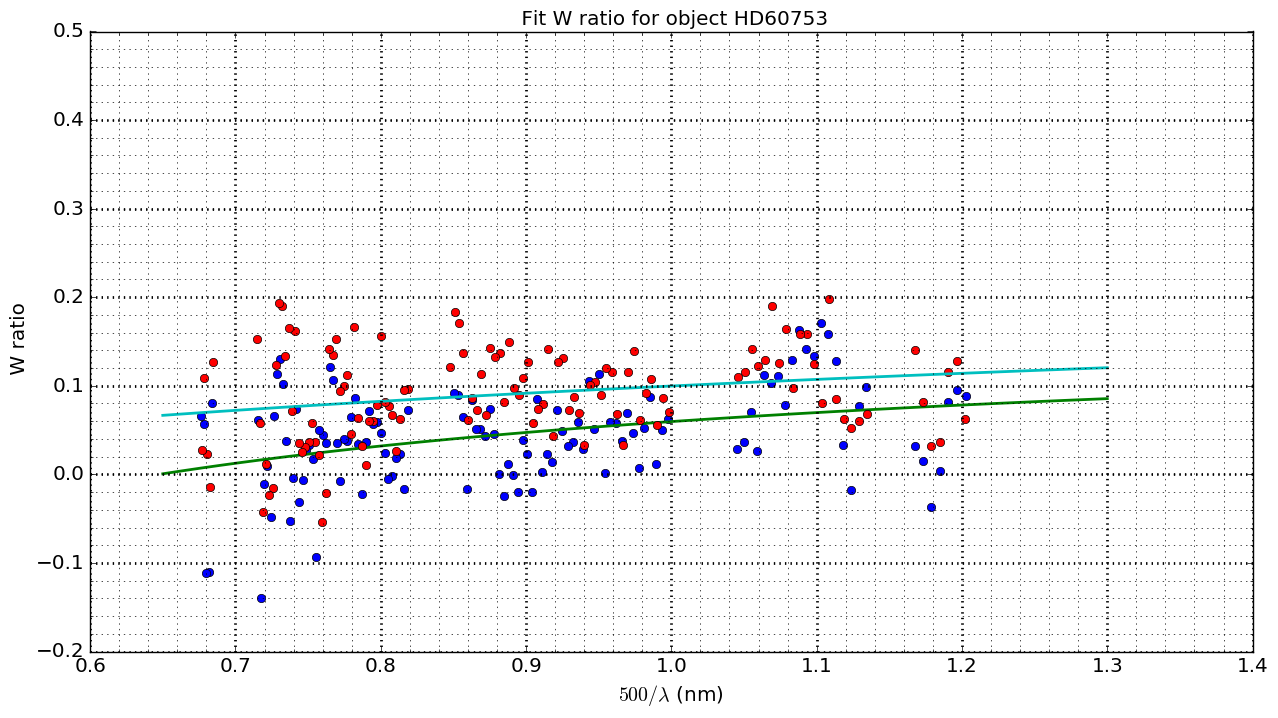

In [317]:
fitoptparam_cut1,all_dzrel_cut1,fitperr_cut1,fitchi2_cut1=NonLinearFitExtinction1(all_ratiowl_cut1,all_ratioratio_cut1,all_dzam_cut1)

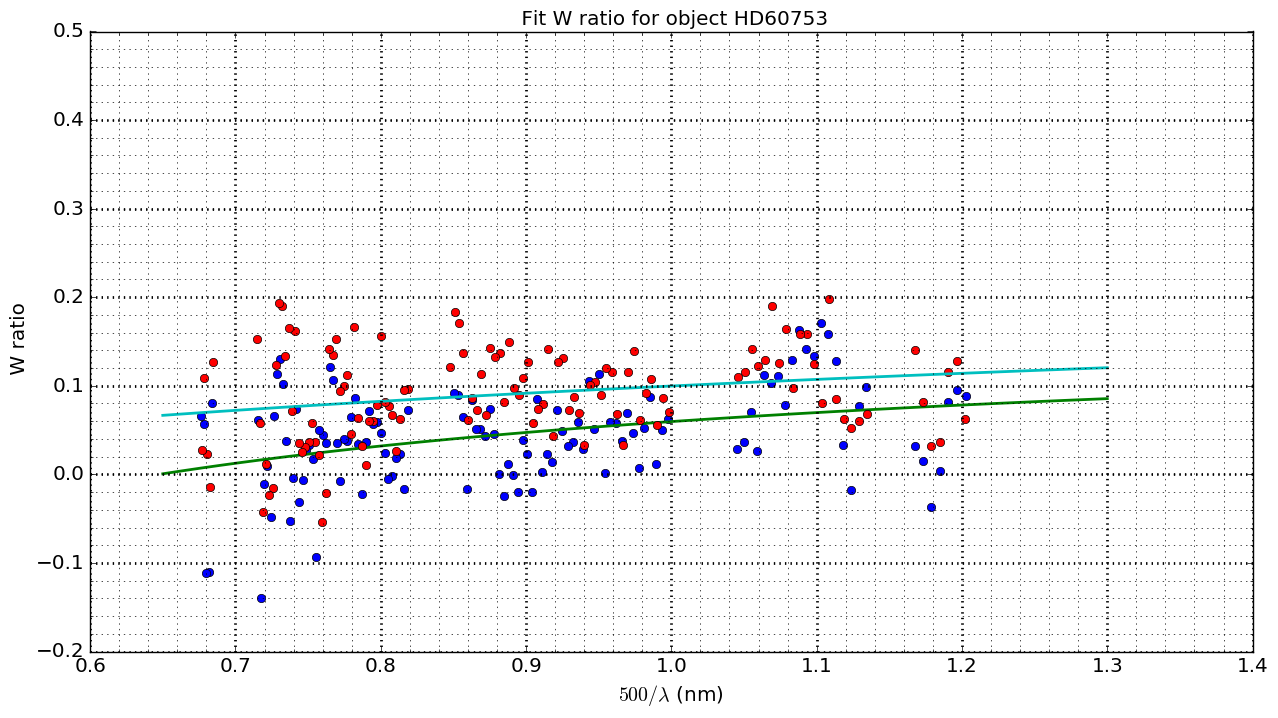

In [318]:
fitoptparam_cut2,all_dzrel_cut2,fitperr_cut2,fitchi2_cut2=NonLinearFitExtinction1(all_ratiowl_cut2,all_ratioratio_cut2,all_dzam_cut2)

## Component 1 : z < zcut
----------------------------------

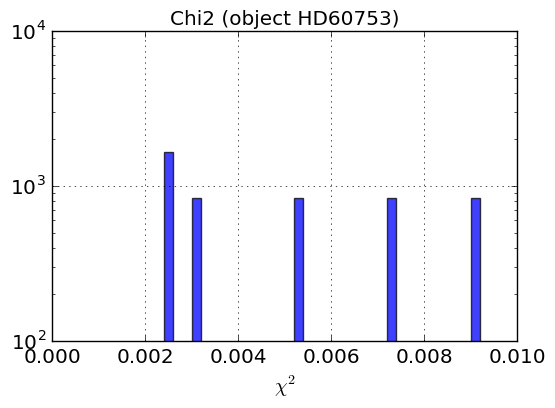

In [319]:
plt.figure(figsize=(6,4.))
n, bins, patches = plt.hist(fitchi2_cut1, 50, normed=1, range=[0,0.01],facecolor='blue', alpha=0.75)
plt.yscale('log', nonposy='clip')
plt.grid(True)
plt.xlabel("$\chi^2$")
figtitle='Chi2 (object {})'.format(object_name)
plt.title(figtitle)

In [320]:
def GetMeanAndSigma(arr):
    themean=np.mean(arr)
    thevariance=np.var(arr)
    thesigma=np.sqrt(thevariance)
    newmean=np.trunc(themean*1000)/1000
    newsigma=np.trunc(thesigma*1000)/1000
    #newmean=np.round(themean,3)
    #newsigma=np.round(thesigma,3)
    #newmean=np.rint(themean*1000)/1000
    #newsigma=np.rint(thesigma*1000)/1000
    thevariation=newsigma/newmean
    thevaria=np.trunc(thevariation*100)
    return newmean,newsigma,thevaria

### grey attenuation

In [321]:
GetMeanAndSigma(fitoptparam_cut1[:,0])

(0.26000000000000001, 1.865, 717.0)

In [322]:
print "median = ",np.median(fitoptparam_cut1[:,0])
print "average = ",np.average(fitoptparam_cut1[:,0])
print "std = ",np.std(fitoptparam_cut1[:,0])

median =  0.0607131371527
average =  0.260920804021
std =  1.86502735004


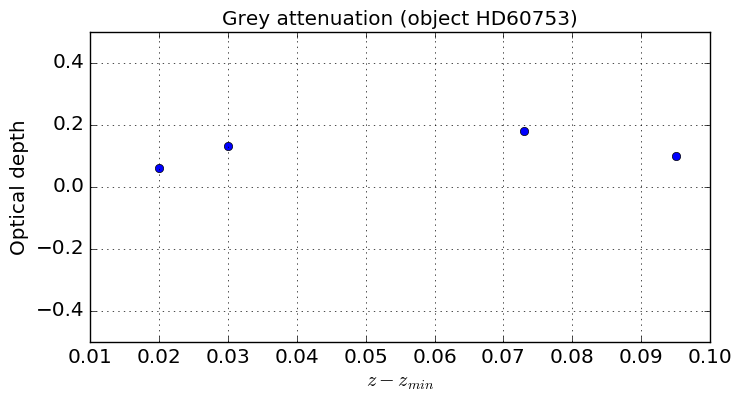

In [323]:
plt.figure(figsize=(8,4.))
greyattenuation=fitoptparam_cut1[:,0]
plt.plot(all_dzrel_cut1,fitoptparam_cut1[:,0],'o')
plt.ylim(-0.5,0.5)
plt.grid()
plt.xlabel("$z-z_{min}$")
plt.ylabel("Optical depth")

figtitle='Grey attenuation (object {})'.format(object_name)
plt.title(figtitle)

figfilename=os.path.join(dir_top_images,'GreyAttvsDz1.pdf')
plt.savefig(figfilename)

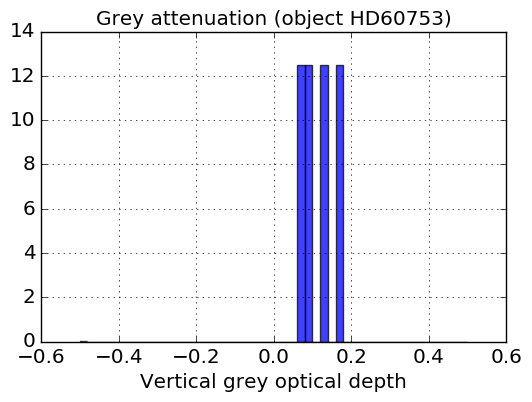

In [324]:
plt.figure(figsize=(6,4.))
n, bins, patches = plt.hist(fitoptparam_cut1[:,0], 50, normed=1, range=[-0.5,0.5],facecolor='blue', alpha=0.75)
plt.grid()
plt.xlabel("Vertical grey optical depth")
figtitle='Grey attenuation (object {})'.format(object_name)
plt.title(figtitle)
figfilename=os.path.join(dir_top_images,'GreyAttHisto1.pdf')
plt.savefig(figfilename)

### Aerosols  

In [325]:
GetMeanAndSigma(fitoptparam_cut1[:,1])

(-0.152, 1.831, -1204.0)

In [326]:
print "median = ",np.median(fitoptparam_cut1[:,1])
print "average = ",np.average(fitoptparam_cut1[:,1])
print "std = ",np.std(fitoptparam_cut1[:,1])

median =  0.0189060576551
average =  -0.152688820445
std =  1.83143467799


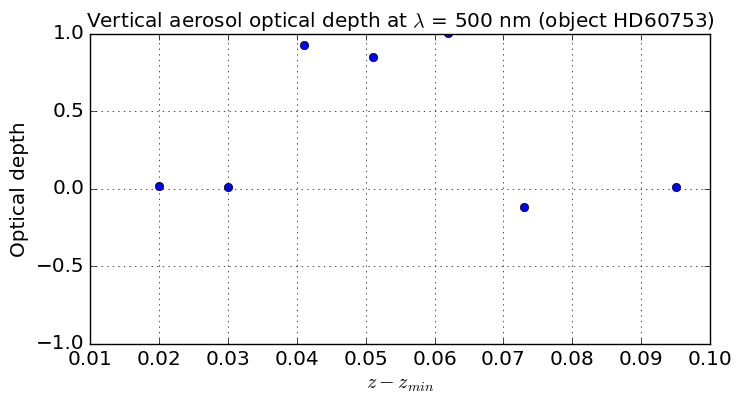

In [327]:
plt.figure(figsize=(8,4.))
plt.plot(all_dzrel_cut1,fitoptparam_cut1[:,1],'o')
plt.ylim(-1,1)
plt.grid()

figtitle="Vertical aerosol optical depth at $\lambda$ = 500 nm (object {})".format(object_name)
plt.title(figtitle)
plt.xlabel("$z-z_{min}$")
plt.ylabel("Optical depth")
figfilename=os.path.join(dir_top_images,'AerAttvsDz1.pdf')
plt.savefig(figfilename)

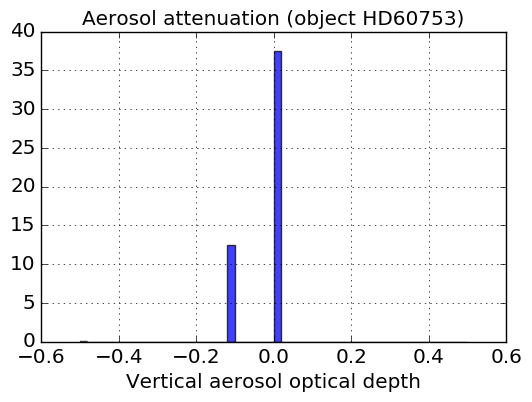

In [328]:
plt.figure(figsize=(6,4.))
n, bins, patches = plt.hist(fitoptparam_cut1[:,1], 50, normed=1, range=[-0.5,0.5],facecolor='blue', alpha=0.75)
plt.grid()
plt.xlabel("Vertical aerosol optical depth")
plt.title("Aerosol attenuation")
figtitle="Aerosol attenuation (object {})".format(object_name)
plt.title(figtitle)
figfilename=os.path.join(dir_top_images,'AerAttHisto1.pdf')
plt.savefig(figfilename)

### Angstrom exponent

In [329]:
GetMeanAndSigma(fitoptparam_cut1[:,2])

(1.845, 5.101, 276.0)

In [330]:
print "median = ",np.median(fitoptparam_cut1[:,2])
print "average = ",np.average(fitoptparam_cut1[:,2])
print "std = ",np.std(fitoptparam_cut1[:,2])

median =  0.0714857603647
average =  1.84533177002
std =  5.10113183036


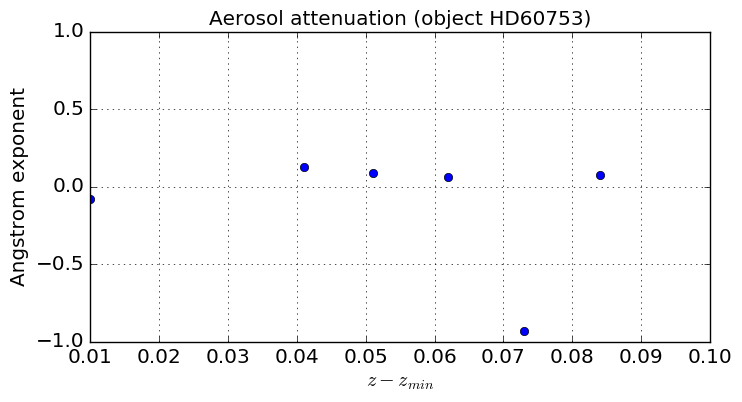

In [331]:
plt.figure(figsize=(8,4.))
plt.plot(all_dzrel_cut1,fitoptparam_cut1[:,2],'o')
plt.ylim(-1,1)
plt.grid()
figtitle="Aerosol attenuation (object {})".format(object_name)
plt.title(figtitle)
plt.xlabel("$z-z_{min}$")
plt.ylabel("Angstrom exponent")
figfilename=os.path.join(dir_top_images,'AerAngstrvsDz1.pdf')
plt.savefig(figfilename)

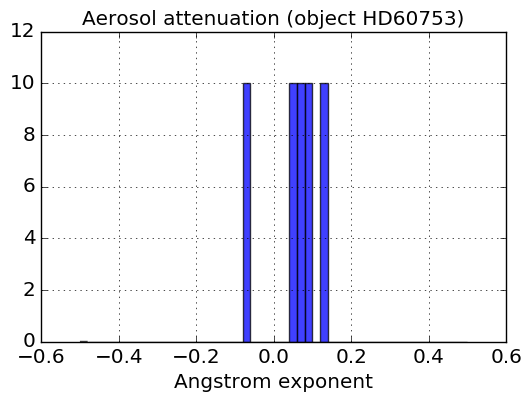

In [332]:
plt.figure(figsize=(6,4.))
n, bins, patches = plt.hist(fitoptparam_cut1[:,2], 50, normed=1, range=[-0.5,0.5],facecolor='blue', alpha=0.75)
plt.grid()
plt.xlabel("Angstrom exponent")
figtitle="Aerosol attenuation (object {})".format(object_name)
plt.title(figtitle)
figfilename=os.path.join(dir_top_images,'AerAngstrHisto1.pdf')
plt.savefig(figfilename)

## Component 2 : z > zcut
----------------------------------

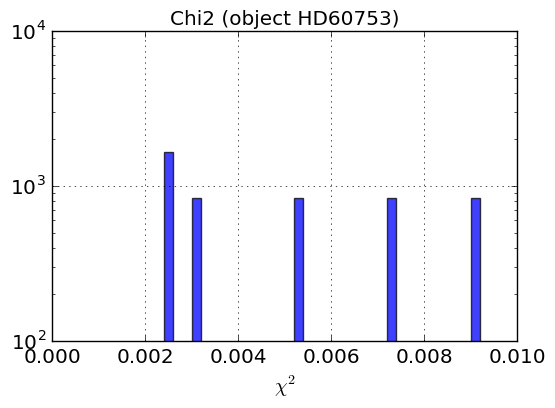

In [333]:
plt.figure(figsize=(6,4.))
n, bins, patches = plt.hist(fitchi2_cut2, 50, normed=1, range=[0,0.01],facecolor='blue', alpha=0.75)
plt.yscale('log', nonposy='clip')
plt.grid(True)
plt.xlabel("$\chi^2$")
figtitle='Chi2 (object {})'.format(object_name)
plt.title(figtitle)

#### Grey attenuation

In [334]:
GetMeanAndSigma(fitoptparam_cut2[:,0])

(0.26000000000000001, 1.865, 717.0)

In [335]:
print "median = ",np.median(fitoptparam_cut2[:,0])
print "average = ",np.average(fitoptparam_cut2[:,0])
print "std = ",np.std(fitoptparam_cut2[:,0])


median =  0.0607131371527
average =  0.260920804021
std =  1.86502735004


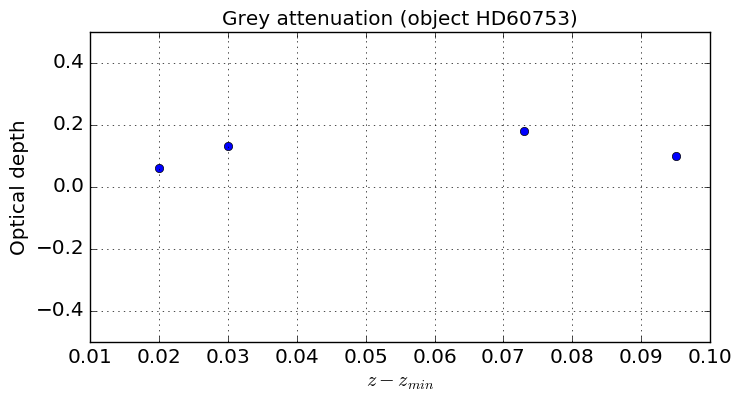

In [336]:
plt.figure(figsize=(8,4.))
greyattenuation=fitoptparam_cut2[:,0]
plt.plot(all_dzrel_cut2,fitoptparam_cut2[:,0],'o')
plt.ylim(-0.5,0.5)
plt.grid()
plt.xlabel("$z-z_{min}$")
plt.ylabel("Optical depth")

figtitle='Grey attenuation (object {})'.format(object_name)
plt.title(figtitle)

figfilename=os.path.join(dir_top_images,'GreyAttvsDz2.pdf')
plt.savefig(figfilename)

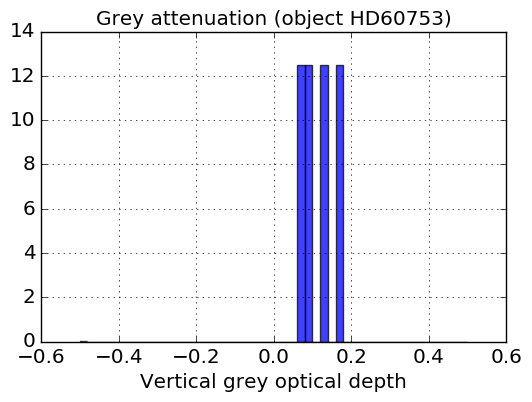

In [337]:
plt.figure(figsize=(6,4.))
n, bins, patches = plt.hist(fitoptparam_cut2[:,0], 50, normed=1, range=[-0.5,0.5],facecolor='blue', alpha=0.75)
plt.grid()
plt.xlabel("Vertical grey optical depth")
figtitle='Grey attenuation (object {})'.format(object_name)
plt.title(figtitle)
figfilename=os.path.join(dir_top_images,'GreyAttHisto2.pdf')
plt.savefig(figfilename)

### Aerosols

In [338]:
GetMeanAndSigma(fitoptparam_cut2[:,1])

(-0.152, 1.831, -1204.0)

In [339]:
print "median = ",np.median(fitoptparam_cut2[:,1])
print "average = ",np.average(fitoptparam_cut2[:,1])
print "std = ",np.std(fitoptparam_cut2[:,1])

median =  0.0189060576551
average =  -0.152688820445
std =  1.83143467799


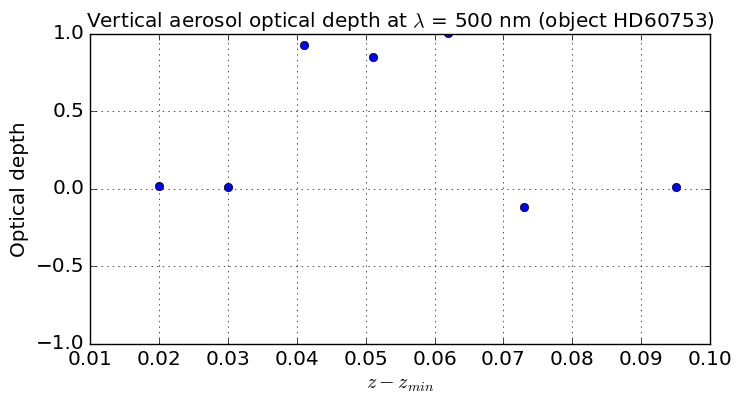

In [340]:
plt.figure(figsize=(8,4.))
plt.plot(all_dzrel_cut2,fitoptparam_cut2[:,1],'o')
plt.ylim(-1,1)
plt.grid()

figtitle="Vertical aerosol optical depth at $\lambda$ = 500 nm (object {})".format(object_name)
plt.title(figtitle)
plt.xlabel("$z-z_{min}$")
plt.ylabel("Optical depth")
figfilename=os.path.join(dir_top_images,'AerAttvsDz2.pdf')
plt.savefig(figfilename)

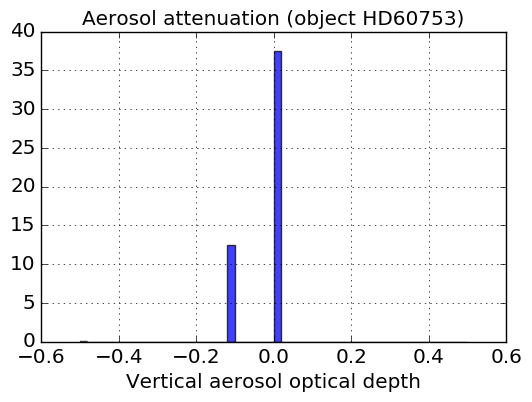

In [341]:
plt.figure(figsize=(6,4.))
n, bins, patches = plt.hist(fitoptparam_cut2[:,1], 50, normed=1, range=[-0.5,0.5],facecolor='blue', alpha=0.75)
plt.grid()
plt.xlabel("Vertical aerosol optical depth")
plt.title("Aerosol attenuation")
figtitle="Aerosol attenuation (object {})".format(object_name)
plt.title(figtitle)
figfilename=os.path.join(dir_top_images,'AerAttHisto2.pdf')
plt.savefig(figfilename)

### Angstrom

In [342]:
GetMeanAndSigma(fitoptparam_cut2[:,2])

(1.845, 5.101, 276.0)

In [343]:
print "median = ",np.median(fitoptparam_cut2[:,2])
print "average = ",np.average(fitoptparam_cut2[:,2])
print "std = ",np.std(fitoptparam_cut2[:,2])

median =  0.0714857603647
average =  1.84533177002
std =  5.10113183036


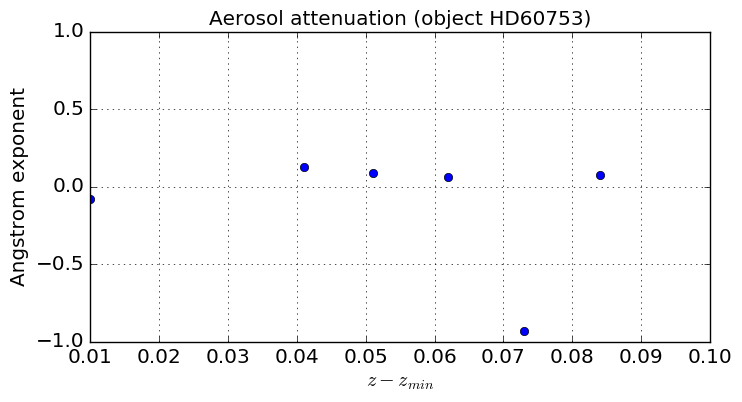

In [344]:
plt.figure(figsize=(8,4.))
plt.plot(all_dzrel_cut2,fitoptparam_cut2[:,2],'o')
plt.ylim(-1,1)
plt.grid()
figtitle="Aerosol attenuation (object {})".format(object_name)
plt.title(figtitle)
plt.xlabel("$z-z_{min}$")
plt.ylabel("Angstrom exponent")
figfilename=os.path.join(dir_top_images,'AerAngstrvsDz2.pdf')
plt.savefig(figfilename)

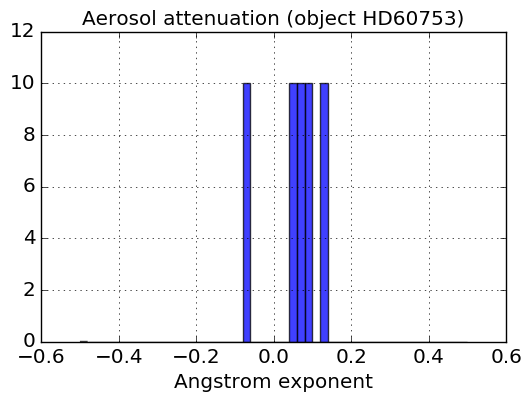

In [345]:
plt.figure(figsize=(6,4.))
n, bins, patches = plt.hist(fitoptparam_cut2[:,2], 50, normed=1, range=[-0.5,0.5],facecolor='blue', alpha=0.75)
plt.grid()
plt.xlabel("Angstrom exponent")
figtitle="Aerosol attenuation (object {})".format(object_name)
plt.title(figtitle)
figfilename=os.path.join(dir_top_images,'AerAngstrHisto2.pdf')
plt.savefig(figfilename)

In [346]:
XMIN=0.65
XMAX=1.3

In [347]:
XminBin=np.arange(XMIN,XMAX,0.05)
XmaxBin=np.arange(XMIN+0.05,XMAX+0.05,0.05)

In [348]:
XaverBin=(XminBin+XmaxBin)/2
    

In [349]:
print XminBin
print XmaxBin
print XaverBin

[ 0.65  0.7   0.75  0.8   0.85  0.9   0.95  1.    1.05  1.1   1.15  1.2
  1.25]
[ 0.7   0.75  0.8   0.85  0.9   0.95  1.    1.05  1.1   1.15  1.2   1.25
  1.3 ]
[ 0.675  0.725  0.775  0.825  0.875  0.925  0.975  1.025  1.075  1.125
  1.175  1.225  1.275]


In [350]:
theibin=np.where(np.logical_and(XminBin<=0.84,XmaxBin>0.84))

In [351]:
len(XminBin)

13

In [352]:
print theibin[0][0]

3


In [353]:
a=np.empty(0)

In [354]:
a=np.append(a,1)

In [355]:
a

array([ 1.])

### first simple model without Rayleigh 

In [356]:
def fullextinct(x, a, b, c ):
    "Model of extinction containing a contamination with residual Rayleigh scattering"
    return a + b * x**c 

In [357]:
def badjacfullextinct(x, a, b, c ):
    "Model of extinction containing a contamination with residual Rayleigh scattering"
    jac1=1 
    jac2=x**c
    jac3=b*x**c*np.log(x)
    return np.array([jac1,jac2,jac3])

In [358]:
#def myDfun( a,b,c, xdata, ydata, f ) :
def myDfun( xdata,a,b,c) :    
    jac1=np.ones(len(xdata))
    jac2=xdata**c
    jac3=b*xdata**c*np.log(xdata)
    res = np.vstack( ( jac1, jac2 , jac3 ) ).T
    return res

In [359]:
def FitFullExtinct(thex,they,theerry):

    x=np.copy(thex)
    y=np.copy(they)
    ey=np.copy(theerry)
    
    z = np.polyfit(x,y, 1) # start a linear fit to find initialisation parameter
    
    z=np.append(z,1.) # add angstrom exponent
    #z=np.append(z,0.01) # add a tiny contribution for Raleigh
    
    
    popt, pcov = curve_fit(fullextinct,x,y,sigma=ey,jac=myDfun,bounds=([0,0.,0.1], [0.5, 0.5, 4.]))
    #popt, pcov = curve_fit(fullextinct,x,y,sigma=ey,jac=myDfun)
    perr = np.sqrt(np.diag(pcov))
    return popt,perr

### second complex  model with Rayleigh

In [360]:
def fullextinct_r(x, a, b, c,d ):
    "Model of extinction containing a contamination with residual Rayleigh scattering"
    return a + b * x**c + d*x**4

In [361]:
def myDfun_r( xdata,a,b,c,d) :    
    jac1=np.ones(len(xdata))
    jac2=xdata**c
    jac3=b*xdata**c*np.log(xdata)
    jac4=xdata**4
    res = np.vstack( ( jac1, jac2 , jac3, jac4 ) ).T
    return res

In [362]:
def FitFullExtinct_r(thex,they,theerry):

    x=np.copy(thex)
    y=np.copy(they)
    ey=np.copy(theerry)
    
    z = np.polyfit(x,y, 1) # start a linear fit to find initialisation parameter
    
    z=np.append(z,0.) # add angstrom exponent
    #z=np.append(z,0.01) # add a tiny contribution for Raleigh
    
    #popt, pcov = curve_fit(fullextinct,x,y,p0=z,sigma=ey,absolute_sigma=True)
    #popt, pcov = curve_fit(fullextinct,x,y,p0=z,sigma=ey,absolute_sigma=False)
    popt, pcov = curve_fit(fullextinct_r,x,y,sigma=ey,jac=myDfun_r,bounds=([0,0.,0.1,0.], [0.5, 0.5, 3.,0.5]))
    perr = np.sqrt(np.diag(pcov))
    return popt,perr

In [363]:
def NonLinearFitExtinction2(all_ratiowl,all_ratioratio,all_dzam,figtitle=' Fit W ratio with grey + aerosol extinct for object {}'):
    """
    Fit without rayleigh
    """

    NBRATIO=len(all_ratioratio)
    
    
    XMIN=0.65
    XMAX=1.3
    
    YMAX=0.5
    YMIN=-0.2

    # Defines 13 bins in 500/lambda where histograms will be done
    XminBin=np.arange(XMIN,XMAX,0.05)
    XmaxBin=np.arange(XMIN+0.05,XMAX+0.05,0.05)
    XaverBin=(XminBin+XmaxBin)/2.
 
    NBBINS=XminBin.shape[0]
    
    all_histos=[]
    
    for ibin in np.arange(NBBINS):
        all_histos.append(np.empty(0))
        
    
    xfit=np.linspace(XMIN,XMAX,50)
    
    fitoptparam= []
    fitperr= []
    fitchi2=[]
    all_dzrel= []
    
    all_X = []
    all_Y = []
    all_EY = []
    all_N = []
    
    fig, ax = plt.subplots(1, 1, figsize=(15,8))
    
    for index in np.arange(NBRATIO): ## Loop on ratio
        dzam=all_dzam[index]
        if dzam != 0 and all_expo[index]>0  : 
            all_dzrel.append(dzam)
            
                        
            x_set=500./all_ratiowl[index]
            y_set=-2.5*np.log10(all_ratioratio[index])/dzam   ### Here divide by dzam to remove airmass dependence
            
            wlcount=0 # counter
            for x in x_set:
                y=y_set[wlcount]
                theibin=np.where(np.logical_and(XminBin<=x,XmaxBin>x))[0][0]
                all_histos[theibin]=np.append(all_histos[theibin],y)
                wlcount+=1   # increate counter
            
           
            
    for ibin in np.arange(NBBINS-2):
        theN=all_histos[ibin].shape[0]
        if theN > 3:
            all_N.append(theN)
            all_X.append(XaverBin[ibin])
            all_Y.append(np.median(all_histos[ibin]))
            all_EY.append(np.std(all_histos[ibin])/np.sqrt(theN))             
        
        
    popt,perr=FitFullExtinct(all_X,all_Y,all_EY)  # No Rayleigh
    #popt,perr=FitFullExtinct_r(all_X,all_Y,all_EY)  
    
    xfit=np.linspace(XMIN,XMAX,50)
    yfit=fullextinct(xfit, popt[0], popt[1], popt[2] )
    
    plt.plot(xfit,yfit,'b-')
            
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True)
    #ax.grid(b=True, which='minor', color='k', linewidth=0.5)        
            
    #ax.set_ylim(YMIN,YMAX)        
     
    plt.errorbar(all_X,all_Y,yerr=all_EY,fmt='o',color="red")                      
                          
    title=figtitle.format(object_name)
    ax.set_title(title)
    ax.set_ylabel(" W ratio")
    ax.set_xlabel("$500/\lambda$ (nm)")
    
    figfilename=os.path.join(dir_top_images,'FitNonLinearExtinction2_Wratio.pdf')
    plt.savefig(figfilename)
    return popt,perr
   
        
  
        

In [364]:
def NonLinearFitExtinction2_r(all_ratiowl,all_ratioratio,all_dzam,figtitle=' Fit W ratio with grey + aerosol + resid rayleigh extinct  for object {}'):
    
    """
    Fit with Rayleigh
    """

    NBRATIO=len(all_ratioratio)
    
    
    XMIN=0.65
    XMAX=1.3
    
    YMAX=0.5
    YMIN=-0.2

    # Defines 13 bins in 500/lambda where histograms will be done
    XminBin=np.arange(XMIN,XMAX,0.05)
    XmaxBin=np.arange(XMIN+0.05,XMAX+0.05,0.05)
    XaverBin=(XminBin+XmaxBin)/2.
 
    NBBINS=XminBin.shape[0]
    
    all_histos=[]
    
    for ibin in np.arange(NBBINS):
        all_histos.append(np.empty(0))
        
    
    xfit=np.linspace(XMIN,XMAX,50)
    
    fitoptparam= []
    fitperr= []
    fitchi2=[]
    all_dzrel= []
    
    all_X = []
    all_Y = []
    all_EY = []
    all_N = []
    
    fig, ax = plt.subplots(1, 1, figsize=(15,8))
    
    for index in np.arange(NBRATIO): ## Loop on ratio
        dzam=all_dzam[index]
        if dzam != 0 and all_expo[index]>0  : 
            all_dzrel.append(dzam)
            
                        
            x_set=500./all_ratiowl[index]
            y_set=-2.5*np.log10(all_ratioratio[index])/dzam   ### Here divide by dzam to remove airmass dependence
            
            wlcount=0 # counter
            for x in x_set:
                y=y_set[wlcount]
                theibin=np.where(np.logical_and(XminBin<=x,XmaxBin>x))[0][0]
                all_histos[theibin]=np.append(all_histos[theibin],y)
                wlcount+=1   # increate counter
            
           
            
    for ibin in np.arange(NBBINS-2):
        theN=all_histos[ibin].shape[0]
        if theN > 3:
            all_N.append(theN)
            all_X.append(XaverBin[ibin])
            all_Y.append(np.median(all_histos[ibin]))
            all_EY.append(np.std(all_histos[ibin])/np.sqrt(theN))             
        
        
    #popt,perr=FitFullExtinct(all_X,all_Y,all_EY)  
    popt,perr=FitFullExtinct_r(all_X,all_Y,all_EY)  
    
    xfit=np.linspace(XMIN,XMAX,50)
    yfit=fullextinct(xfit, popt[0], popt[1], popt[2] )
    
    plt.plot(xfit,yfit,'b-')
            
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True)
    #ax.grid(b=True, which='minor', color='k', linewidth=0.5)        
            
    #ax.set_ylim(YMIN,YMAX)        
     
    plt.errorbar(all_X,all_Y,yerr=all_EY,fmt='o',color="red")                      
                          
    title=figtitle.format(object_name)
    ax.set_title(title)
    ax.set_ylabel(" W ratio")
    ax.set_xlabel("$500/\lambda$ (nm)")
    
    figfilename=os.path.join(dir_top_images,'FitNonLinearExtinction2_Wratio_r.pdf')
    plt.savefig(figfilename)
    return popt,perr
   
        
  
        

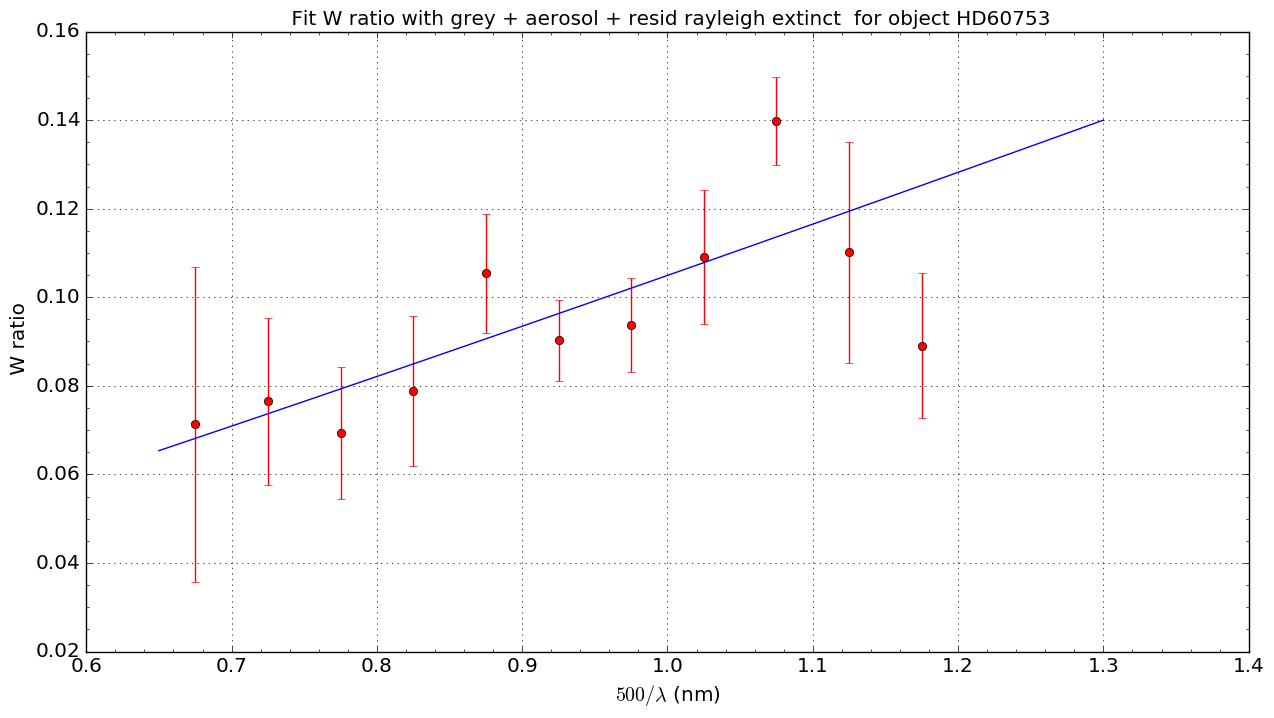

In [365]:
popt1,perr1=NonLinearFitExtinction2_r(all_ratiowl_cut1,all_ratioratio_cut1,all_dzam_cut1)

In [366]:
popt1

array([  1.07381909e-19,   1.04924837e-01,   1.09905088e+00,
         1.48698775e-22])

In [367]:
perr1

array([  2.64248749,   2.15832535,  41.72582101,   0.49144534])

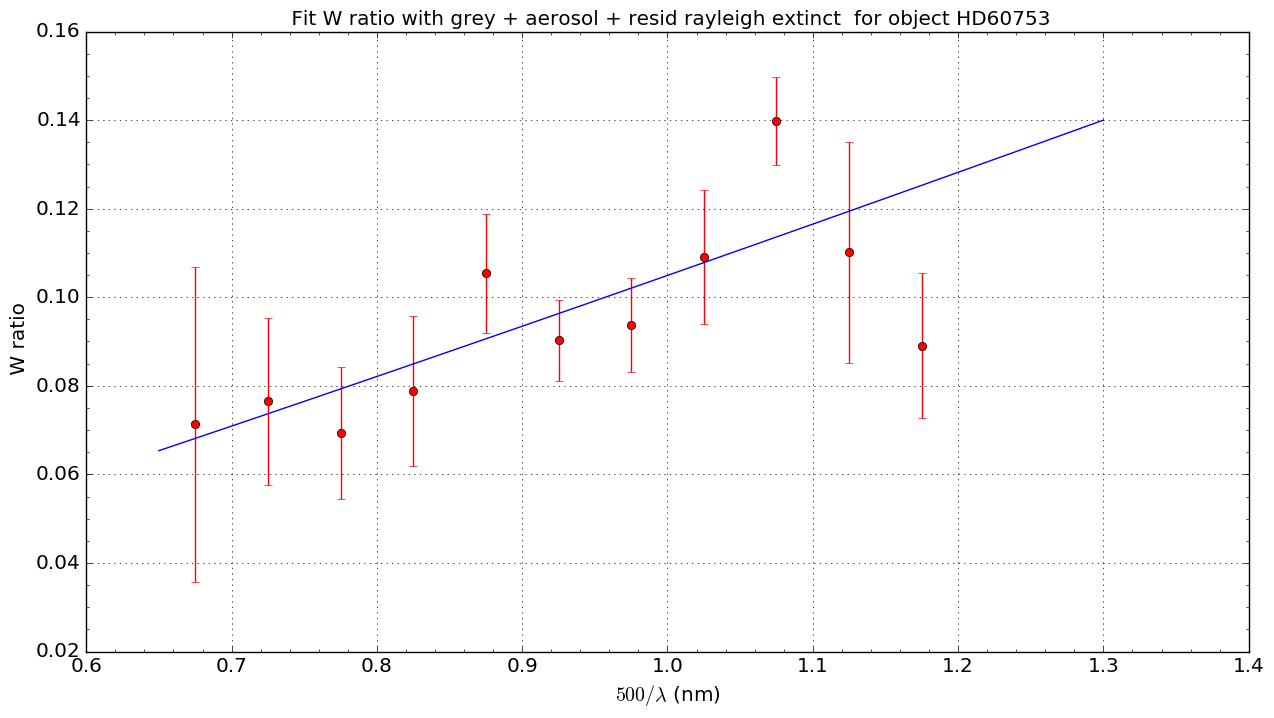

In [368]:
popt2,perr2=NonLinearFitExtinction2_r(all_ratiowl_cut2,all_ratioratio_cut2,all_dzam_cut2)

In [369]:
popt2

array([  1.07384604e-19,   1.04924837e-01,   1.09905088e+00,
         1.48698775e-22])

In [370]:
perr2

array([  2.64248749,   2.15832535,  41.72582101,   0.49144534])